In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
sys.path.append('/Users/gracecolverd/New_dataset')
from src import * 

In [233]:
import os
import sys
import time
import geopandas as gpd 
import pandas as pd 
import glob 
import re
import matplotlib.pyplot as plt 
from shapely.geometry import Point, Polygon
from shapely.geometry import box
sys.path.append('/Users/gracecolverd/New_dataset')

from src.postcode_utils import find_postcode_for_ONSUD_file, find_data_pc

from src.multi_thread import run_batching, merge_temp_logs_to_main , generate_batch_list    

from src.pre_process_buildings import load_avg_floor_count ,update_avg_floor_count, get_average_heights_table, update_height_with_average, update_height_with_average_flexifc

import matplotlib.pyplot as plt 
plt.style.use("seaborn-dark-palette")

# Access the color cycle used in this style
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# from src import process_postcode, postcode_median_age_batch_fn , run_batching, find_data_pc
# from src import calculate_modal_age_band, calc_med_attr , postcode_modal_batch_fn, gen_postcode_areas
# from src import postcode_area_vars_batch_fn , fill_premise_floor_types


ImportError: cannot import name 'update_height_with_average_flexifc' from 'src.pre_process_buildings' (/Users/gracecolverd/New_dataset/src/pre_process_buildings.py)

In [234]:
def update_height_with_average_flexifc(df, input_col, fc_col, avg_table, suffix):
    """Update the height column with averages based on age, floor count, and use."""
    # Merge with the average table
    df = pd.merge(df, avg_table, left_on=['premise_age', fc_col, 'map_simple_use'], right_on=['premise_age', 'premise_floor_count', 'map_simple_use'], how='left')
    
    # Update heights with averages where applicable
    update_col_name = f'{input_col}_{suffix}'
    df[update_col_name] = np.where(df[input_col] == 0, df['weighted_average_height'], df[input_col])
    
    # Drop the temporary column
    df.drop('weighted_average_height', axis=1, inplace=True)
    return df

In [53]:


from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
import numpy as np


def min_side(polygon):

    # Minimum rotated rectangle
    min_rect = polygon.minimum_rotated_rectangle

    # Extract the points of the rectangle to calculate side lengths
    x, y = min_rect.exterior.coords.xy

    # Calculate distances between consecutive points (sides of the rectangle)
    distances = [np.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2) for i in range(1, len(x))]

    # The least width is the minimum side length of the rectangle
    least_width = min(distances)
    return least_width 

    


# Define a mapping of premise types to expected floor counts
expected_floors = {
    'Medium height flats 5-6 storeys': range(5, 7),
    'Small low terraces': [1,2,3, 4],
    '3-4 storey and smaller flats': range(3, 6),
    'Domestic outbuilding': [1,2,3],   
    'Tall terraces 3-4 storeys': range(3, 6),
    'Large semi detached': [2, 3,4,5],
    'Standard size detached': [1, 2,3,4],
    'Standard size semi detached': [1,2,3],
    '2 storeys terraces with t rear extension': [1,2,3], 
    'Semi type house in multiples': range(1, 4),
    'Tall flats 6-15 storeys': range(6, 17),
    'Large detached': [2, 3, 4],
    'Very tall point block flats': range(14, 30),  # Example range
    'Very large detached': [2, 3, 4],
    'Planned balanced mixed estates': range(1, 4),
    'Linked and step linked premises': range(1, 3)
}

def validate_floor_counts(df, expected_floors):
    # Initialize the new column with NaNs
    df['validated_ptype_floor_count'] = np.nan
    df['premise_floor_count'] = df['premise_floor_count'].fillna(0)
    # Check if each premise's floor count is within the expected range
    for index, row in df.iterrows():
        premise_type = row['premise_type']
        floor_count = int(row['premise_floor_count'] )

        # Get the expected range for the premise type
        expected_range = expected_floors.get(premise_type)
        print(expected_range)
        print(floor_count)
        # check for nones 
        if row['premise_type'] is None:
            continue 

        # Set to the original floor count if valid, otherwise keep as NaN
        if expected_range and floor_count in expected_range:
            df.at[index, 'validated_ptype_floor_count'] = floor_count





In [90]:
import unittest
from shapely.geometry import Polygon
import numpy as np

def min_side(polygon):
    # Minimum rotated rectangle
    min_rect = polygon.minimum_rotated_rectangle

    # Extract the points of the rectangle to calculate side lengths
    x, y = min_rect.exterior.coords.xy

    # Calculate distances between consecutive points (sides of the rectangle)
    distances = [np.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2) for i in range(1, len(x))]

    # The least width is the minimum side length of the rectangle
    least_width = min(distances)
    return least_width 

class TestMinSideFunction(unittest.TestCase):
    def test_square(self):
        # A square polygon
        square = Polygon([(0, 0), (4, 0), (4, 4), (0, 4)])
        
        self.assertAlmostEqual(min_side(square), 4)

    def test_rectangle(self):
        # A rectangle, longer width should not affect the least width
        rectangle = Polygon([(0, 0), (8, 0), (8, 2), (0, 2)])
        
        self.assertAlmostEqual(min_side(rectangle), 2)

    def test_triangle(self):
        # A triangle
        triangle = Polygon([(0, 0), (4, 0), (2, 4)])
        # Expected least width requires geometric calculation or manual verification
        expected_least_width = 2.3094  # This would need accurate calculation
        print(min_side(triangle))
        self.assertAlmostEqual(min_side(triangle), expected_least_width, places=4)

    def test_complex_shape(self):
        # More complex shape
        complex_shape = Polygon([(0, 0), (5, 0), (5, 6), (3, 6), (3, 4), (0,4)])

        # Expected value would need geometric calculation
        expected_least_width = 5   # This would need accurate calculation
        print(min_side(complex_shape))
        self.assertAlmostEqual(min_side(complex_shape), expected_least_width, places=4)

# Run the tests
# if __name__ == '__main__':
#     unittest.main()

def run_tests():
    suite = unittest.TestSuite()
    suite.addTest(TestMinSideFunction("test_square"))
    suite.addTest(TestMinSideFunction("test_triangle"))
    suite.addTest(TestMinSideFunction("test_rectangle"))
    suite.addTest(TestMinSideFunction("test_complex_shape"))
    

    runner = unittest.TextTestRunner()
    runner.run(suite)

run_tests()

.F..
FAIL: test_triangle (__main__.TestMinSideFunction.test_triangle)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_4857/2038297592.py", line 38, in test_triangle
    self.assertAlmostEqual(min_side(triangle), expected_least_width, places=4)
AssertionError: 3.5777087639996625 != 2.3094 within 4 places (1.2683087639996624 difference)

----------------------------------------------------------------------
Ran 4 tests in 0.010s

FAILED (failures=1)


3.5777087639996625
5.0


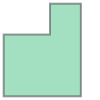

In [87]:
complex_shape = Polygon([(0, 0), (5, 0), (5, 6), (3, 6), (3, 4), (0,4)])
complex_shape

In [34]:
lin = open('/Users/gracecolverd/New_dataset/old/testing/batches/EE/batch_9.txt', 'r' )

In [6]:
from src.pre_process_buildings import pre_process_building_data 

In [4]:
# get bounds of whole geo data frma 
build = gpd.read_file('/Volumes/T9/postcode_data/data/verisk_y2022_V4/bbox_529252.36_186435.25920425786_539252.36_196435.25920425786.gpkg')


total_bounds = build.total_bounds


In [7]:
# # get bounds of whole geo data frma 
build = gpd.read_file('/Volumes/T9/postcode_data/data/verisk_y2022_V4/bbox_529252.36_186435.25920425786_539252.36_196435.25920425786.gpkg')

# total_bounds = build.total_bounds
total_bounds = build.buffer(5000).total_bounds
# total_bounds convert to bounding box 
bbox = box(total_bounds[0], total_bounds[1], total_bounds[2], total_bounds[3])   

# new data 
build = gpd.read_file('/Volumes/T9/Data_downloads/Versik_building_data/2024_03_22_updated_data/UKBuildings_Edition_15_new_format_upn.gpkg', bbox=bbox)   

build2 = pre_process_building_data(build)
data = build2[0].copy() 

res = data[data['premise_use']=='Residential'].copy() 
res['avfloorheight'] = res['height'] / res['floor_count_numeric_FGA']

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/pygeos/constructive.py:175: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


len df  725813


In [9]:
from src.pre_process_buildings import create_height_bucket_col 


print(len(res) ) 

test=res.copy() 

# Apply the conditions with the height range and update 'premise_type'
test.loc[(test['height']==3) & (test['premise_floor_count'] == '2') & (test['uprn_count'] == 0), 'premise_type'] = 'Domestic outbuilding'

test['num_height'] = pd.to_numeric(test['height'], errors = 'coerce' )
test['num_floors'] = pd.to_numeric(test['premise_floor_count'], errors = 'coerce' )
# test=test[~test['num_height'].isna()].copy() 


test['av_fl_height'] = test['num_height'] / test['num_floors']


print(len(test))
test = create_height_bucket_col(test)

test=test[test['premise_type']!='Domestic outbuilding'].copy()

validate_floor_counts(test, expected_floors)

test['validated_av_fl_height'] = test['height'] / test['validated_ptype_floor_count']

In [12]:
test.to_csv('test_res.csv')

In [ ]:
# test= test[(test['av_fl_height']<15) & (test['av_fl_height']> 1.5)]

<AxesSubplot: >

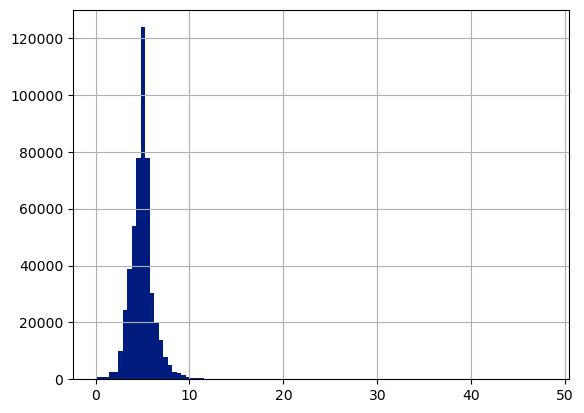

In [21]:
test.validated_av_fl_height.hist(bins=100)

Text(0.5, 1.0, 'Average Floor Height, floor count validated against Premise Type')

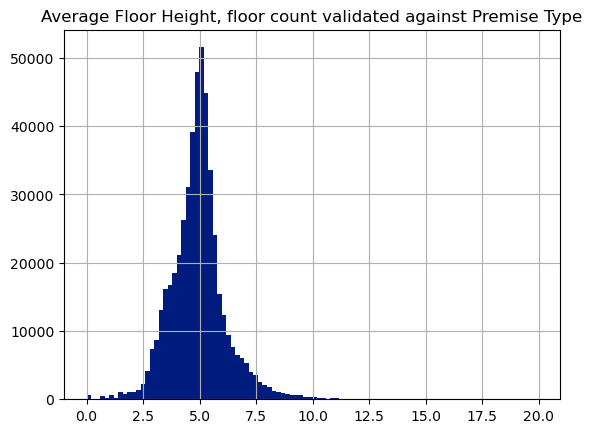

In [24]:
test[test['validated_av_fl_height']< 20].validated_av_fl_height.hist(bins=100)
plt.title('Average Floor Height, floor count validated against Premise Type')

In [231]:
highs = test[test['validated_av_fl_height']> 7.5].copy() 
highs['height_over_area'] = highs['height'] / highs['premise_area']

<AxesSubplot: >

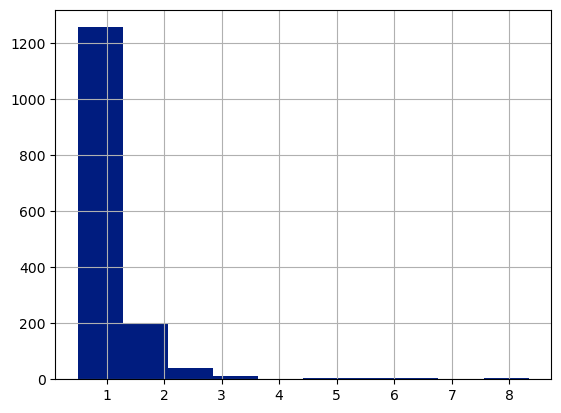

In [52]:
highs[highs['height_over_area'] >0.5  ].height_over_area.hist()

In [68]:
test['min_side'] = test['geometry'].apply(min_side)
test['threex_minside'] = [x * 3 for x in test['min_side']]

In [ ]:
def update_fc_h_av_hght(highs):
    highs['min_side'] = highs['geometry'].apply(min_side)
    highs['threex_minside'] = [x * 3 for x in highs['min_side']]
    highs['validated_height'] = np.where(highs['height'] >= highs['threex_minside'],   np.nan,  highs['height'])
    highs['validated_height'] = highs['validated_height'].fillna(0)
    highs=update_height_with_average_flexifc(highs, 'validated_height', 'floor_count_numeric', glo_hegh, 'glob_fill' )
    highs['validated_fc'] = np.where(highs['height']< highs['threex_minside'] , np.nan, highs['validated_ptype_floor_count'])
    highs = update_avg_floor_count(highs, 'validated_fc', glo_av_flc, 'glob_fill' ) 

    highs['corr_fl_height'] = highs['validated_height_glob_fill'] / highs['validated_fc_glob_fill']
    return highs 


In [ ]:
# fix the global averages 

In [237]:

glo_av_flc = load_avg_floor_count() 

glo_hegh = get_average_heights_table()
glo_hegh.premise_floor_count = pd.to_numeric(glo_hegh.premise_floor_count, errors='coerce')
glo_hegh= glo_hegh[~glo_hegh['premise_floor_count'].isna()]

# # apply min_side to geometry col 
highs['min_side'] = highs['geometry'].apply(min_side)
highs['threex_minside'] = [x * 3 for x in highs['min_side']]
highs['validated_height'] = np.where(highs['height'] >= highs['threex_minside'],   np.nan,  highs['height'])
highs['validated_height'] = highs['validated_height'].fillna(0)
highs=update_height_with_average_flexifc(highs, 'validated_height', 'floor_count_numeric', glo_hegh, 'glob_fill' )
highs['validated_fc'] = np.where(highs['height']< highs['threex_minside'] , np.nan, highs['validated_ptype_floor_count'])
highs = update_avg_floor_count(highs, 'validated_fc', glo_av_flc, 'glob_fill' ) 

highs['corr_fl_height'] = highs['validated_height_glob_fill'] / highs['validated_fc_glob_fill']


In [247]:
highs.corr_fl_height.describe()

count    16234.000000
mean         5.049498
std          0.701317
min          2.735573
25%          4.664193
50%          4.910800
75%          5.445964
max         20.094117
Name: corr_fl_height, dtype: float64

In [249]:
highs.drop(columns=['Unnamed: 0_y', 'Unnamed: 0',  'v3_fl_height'], inplace=True)

In [250]:
highs[highs['corr_fl_height'] > 10] 

premise_age  premise_year  premise_use                     premise_type  \
2894    1980-1989           NaN  Residential     3-4 storey and smaller flats   
2911    1980-1989           NaN  Residential  Medium height flats 5-6 storeys   
3294    1980-1989           NaN  Residential     3-4 storey and smaller flats   
3568    1945-1959           NaN  Residential  Medium height flats 5-6 storeys   
5600    1990-1999           NaN  Residential     3-4 storey and smaller flats   
5691    1980-1989           NaN  Residential     3-4 storey and smaller flats   
5895    1980-1989           NaN  Residential     3-4 storey and smaller flats   
8617    1919-1944           NaN  Residential               Small low terraces   
9764    1990-1999           NaN  Residential     3-4 storey and smaller flats   
9766    1990-1999           NaN  Residential     3-4 storey and smaller flats   
10741   1980-1989           NaN  Residential  Medium height flats 5-6 storeys   
10742   1980-1989           NaN  Residential     3-4 storey and smaller flats   
12060   1990-1999           NaN  Residential     3-4 storey and smaller flats   
12313   1980-1989           NaN  Residential     3-4 storey and smaller flats   
13993   1990-1999           NaN  Residential  Medium height flats 5-6 storeys   
14617   1837-1869           NaN  Residential        Tall terraces 3-4 storeys   
15035    Pre 1837        1776.0  Residential     3-4 storey and smaller flats   

      premise_floor_count_x     height  premise_area  building_area  \
2894                      4  53.500000   1336.500000    1336.500000   
2911                      6  76.199997   2171.399902   25725.199219   
3294                      4  58.099998    638.200012    9086.500000   
3568                      6  71.500000   1211.400024    4440.899902   
5600                      4  61.500000    326.799988    1974.000000   
5691                      4  62.000000   1462.599976    1462.599976   
5895                      4  57.500000    537.599976   37802.699219   
8617                      2  48.799999   2414.000000    2975.199951   
9764                      4  57.900002    996.700012    1595.400024   
9766                      4  57.900002    501.200012    1595.400024   
10741                     6  54.900002    729.599976    6597.899902   
10742                     4  54.900002    832.099976    6597.899902   
12060                     4  54.299999   1334.500000    1334.500000   
12313                     4  55.299999    459.500000    3407.800049   
13993                     6  51.700001    979.400024     979.400024   
14617                     3  40.799999    673.500000    9935.099609   
15035                     4  39.599998    358.200012   12741.700195   

       address_area    gross_area  ... height_over_area validated_height  \
2894      37.599998   5346.000000  ...         0.040030        53.500000   
2911     236.899994  13028.400391  ...         0.035093        76.199997   
3294     116.000000   2552.800049  ...         0.091037        58.099998   
3568     115.400002   7268.399902  ...         0.059023        71.500000   
5600      81.699997   1307.199951  ...         0.188189        61.500000   
5691      36.099998   5850.399902  ...         0.042390        62.000000   
5895      51.200001   2150.399902  ...         0.106957        57.500000   
8617      18.000000   4828.000000  ...         0.020215        48.799999   
9764     332.200012   3986.800049  ...         0.058092        57.900002   
9766            NaN   2004.800049  ...         0.115523        57.900002   
10741     99.500000   4377.600098  ...         0.075247        54.900002   
10742           NaN   3328.399902  ...         0.065978        54.900002   
12060    140.500000   5338.000000  ...         0.040689        54.299999   
12313     36.000000   1838.000000  ...         0.120348        55.299999   
13993     52.900002   5876.399902  ...         0.052787        51.700001   
14617    126.300003   2020.500000  ...         0.060

In [236]:
highs.v1_fl_height.describe()

count    16234.000000
mean         7.009932
std          2.085187
min          2.735573
25%          4.664193
50%          7.700000
75%          8.300000
max         25.350000
Name: v1_fl_height, dtype: float64

/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_4857/1864812060.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'premise_floor_count_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, avg_table, left_on=['premise_age', fc_col, 'map_simple_use'], right_on=['premise_age', 'premise_floor_count', 'map_simple_use'], how='left')


In [219]:
highs.columns

Index(['premise_age', 'premise_year', 'premise_use', 'premise_type', 'height',
       'premise_area', 'building_area', 'address_area', 'gross_area',
       'basement', 'listed_grade', 'element_count', 'bathroom_count',
       'bedroom_count', 'reception_room_count', 'roof_type', 'wall_type',
       'substructure_type', 'glazing_type', 'wall_construction_type',
       'extension_count', 'habitable_rooms', 'open_fireplaces', 'floor_type',
       'distance_building', 'site_id', 'site_area', 'site_non_built_area',
       'site_building_count', 'distance_water', 'verisk_building_id', 'uprn',
       'uprn_count', 'uprn_distance', 'toid', 'map_age', 'map_floors',
       'map_use', 'map_simple_use', 'upn', 'geometry', 'height_numeric',
       'floor_count_numeric', 'height_bucket', 'floor_count_numeric_FGA',
       'floor_count_element_av', 'floor_count_element_av_FGA',
       'height_numeric_FGA', 'listed_bool', 'build_vol_FGA', 'base_floor',
       'build_vol_inc_basement_FGA', 'heated_vol_E

In [220]:
highs[['premise_age', 'validated_ptype_floor_count', 'validated_height_v2', 'validated_height', 'height']]

premise_age  validated_ptype_floor_count  validated_height_v2  \
0       1870-1918                          2.0             9.328387   
1       1870-1918                          2.0             9.328387   
2       1870-1918                          2.0             9.328387   
3       1870-1918                          2.0             9.328387   
4       1870-1918                          2.0             9.328387   
...           ...                          ...                  ...   
16229   1980-1989                          2.0            21.000000   
16230   1837-1869                          2.0            16.100000   
16231    Pre 1837                          2.0            15.800000   
16232   1837-1869                          2.0            15.800000   
16233   1837-1869                          2.0            15.800000   

       validated_height  height  
0                   0.0    19.6  
1                   0.0    15.7  
2                   0.0    15.7  
3                   0.0    15.7  
4                   0.0    15.7  
...                 ...     ...  
16229              21.0    21.0  
16230              16.1    16.1  
16231              15.8    15.8  
16232              15.8    15.8  
16233              15.8    15.8  

[16234 rows x 5 columns]

In [173]:
h_ratio = highs[highs['height_over_area'] >0.5 ].copy() 

In [167]:
# def update_avg_floor_count(df, input_col, avg_table, suffix):
#     """Update DataFrame column with average floor count values based on criteria."""
#     if (df[input_col] == 0).any():
#         raise ValueError('Some floor counts are set to 0, expecting NaN for missing values.')
#     df = pd.merge(df, avg_table, on=['premise_age', 'height_bucket', 'map_simple_use'], how='left')
#     df[f'{input_col}_{suffix}'] = np.where(df[input_col].isna(), df['weighted_average_floor_count'], df[input_col])
#     df.drop('weighted_average_floor_count', axis=1, inplace=True)
#     return df

# def update_height_with_average(df, input_col, avg_table, suffix):
#     """Update the height column with averages based on age, floor count, and use."""
#     # Merge with the average table
#     df = pd.merge(df, avg_table, on=['premise_age', 'premise_floor_count', 'map_simple_use'], how='left')
    
#     # Update heights with averages where applicable
#     update_col_name = f'{input_col}_{suffix}'
#     df[update_col_name] = np.where(df[input_col] == 0, df['weighted_average_height'], df[input_col])
    
#     # Drop the temporary column
#     df.drop('weighted_average_height', axis=1, inplace=True)
#     return df




In [216]:
glo_hegh[glo_hegh['map_simple_use']=='Residential'][glo_hegh['premise_floor_count']==2]

/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_4857/452999182.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  glo_hegh[glo_hegh['map_simple_use']=='Residential'][glo_hegh['premise_floor_count']==2]


Unnamed: 0 map_simple_use   premise_age  premise_floor_count  \
5203        5203    Residential     1837-1869                  2.0   
5220        5220    Residential     1870-1918                  2.0   
5252        5252    Residential     1919-1944                  2.0   
5283        5283    Residential     1945-1959                  2.0   
5316        5316    Residential     1960-1979                  2.0   
5352        5352    Residential     1980-1989                  2.0   
5389        5389    Residential     1990-1999                  2.0   
5421        5421    Residential     Post 1999                  2.0   
5462        5462    Residential      Pre 1837                  2.0   
5484        5484    Residential      Pre 1919                  2.0   
5507        5507    Residential  Unknown date                  2.0   

      weighted_average_height  
5203                 9.821600  
5220                 9.328387  
5252                 8.521362  
5283                 8.151230  
5316                 8.033163  
5352                 8.085548  
5389                 8.281527  
5421                 8.507226  
5462                 9.157595  
5484                 8.541199  
5507                 7.985021

In [142]:
highs[~highs['validated_height'].isna()].head()

premise_age  premise_year  premise_use            premise_type  \
5   1870-1918           NaN  Residential     Large semi detached   
6   1870-1918           NaN  Residential     Large semi detached   
7   1870-1918           NaN  Residential     Large semi detached   
8   1870-1918           NaN  Residential     Large semi detached   
9   1870-1918           NaN  Residential  Standard size detached   

  premise_floor_count  height  premise_area  building_area  address_area  \
5                   2    15.4     94.099998     777.799988    188.199997   
6                   2    15.4     93.000000     777.799988    186.000000   
7                   2    15.4     93.900002     777.799988    187.800003   
8                   2    15.4     93.000000     777.799988    186.000000   
9                   2    15.4    124.599998     777.799988    249.199997   

   gross_area  ... validated_ptype_floor_count validated_av_fl_height  \
5  188.199997  ...                         2.0                    7.7   
6  186.000000  ...                         2.0                    7.7   
7  187.800003  ...                         2.0                    7.7   
8  186.000000  ...                         2.0                    7.7   
9  249.199997  ...                         2.0                    7.7   

   height_over_area  min_side  threex_minside  validated_height  \
5          0.163656  7.324568       21.973705              15.4   
6          0.165591  7.200128       21.600383              15.4   
7          0.164004  7.289890       21.869670              15.4   
8          0.165591  7.193367       21.580102              15.4   
9          0.123596  7.348829       22.046488              15.4   

  validatedheight_valiatedptypeflcount_av_fl_height validated_fc Unnamed: 0  \
5                                               7.7          NaN       2243   
6                                               7.7          NaN       2243   
7                                               7.7          NaN       2243   
8                                               7.7          NaN       2243   
9                                               7.7          NaN       2243   

  validated_fc_glob_fill  
5               2.827782  
6               2.827782  
7               2.827782  
8               2.827782  
9               2.827782  

[5 rows x 71 columns]

In [132]:
highs.columns

Index(['premise_age', 'premise_year', 'premise_use', 'premise_type',
       'premise_floor_count', 'height', 'premise_area', 'building_area',
       'address_area', 'gross_area', 'basement', 'listed_grade',
       'element_count', 'bathroom_count', 'bedroom_count',
       'reception_room_count', 'roof_type', 'wall_type', 'substructure_type',
       'glazing_type', 'wall_construction_type', 'extension_count',
       'habitable_rooms', 'open_fireplaces', 'floor_type', 'distance_building',
       'site_id', 'site_area', 'site_non_built_area', 'site_building_count',
       'distance_water', 'verisk_building_id', 'uprn', 'uprn_count',
       'uprn_distance', 'toid', 'map_age', 'map_floors', 'map_use',
       'map_simple_use', 'upn', 'geometry', 'height_numeric',
       'floor_count_numeric', 'height_bucket', 'floor_count_numeric_FGA',
       'floor_count_element_av', 'floor_count_element_av_FGA',
       'height_numeric_FGA', 'listed_bool', 'build_vol_FGA', 'base_floor',
       'build_vol_in

In [67]:
highs.height_over_area.describe()

count    16234.000000
mean         0.295752
std          0.339891
min          0.007699
25%          0.160494
50%          0.229372
75%          0.330224
max          8.333333
Name: height_over_area, dtype: float64

In [152]:
colors

['#001C7F', '#017517', '#8C0900', '#7600A1', '#B8860B', '#006374']

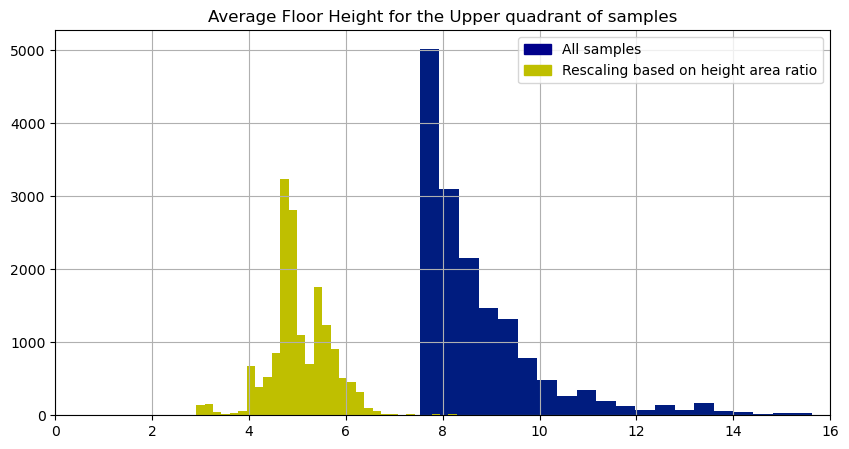

In [245]:
fig, ax = plt.subplots(figsize=(10, 5))

highs.validated_av_fl_height.hist(bins=100, ax=ax)

# highs.v2_fl_height.hist(bins=100, ax=ax, color=colors[1])
# highs.v1_fl_height.hist(bins=100, ax=ax, color=colors[1])
# highs.v3_fl_height.hist(bins=100, ax=ax, color=colors[3])
highs.corr_fl_height.hist(bins=100, ax=ax , color='y')
# cap x axis at 20 
ax.set_xlim(0,16)
ax.set_title('Average Floor Height for the Upper quadrant of samples')
# add custom legend with patches 
import matplotlib.patches as mpatches

# Create the patches for the legend
patch1 = mpatches.Patch(color='darkblue', label='All samples')
patch2 = mpatches.Patch(color='y', label='Correcting based on height area ratio')
# patch2 = mpatches.Patch(color=colors[2], label='Excluding based on Height base ratio and floor count')

# Add the patches to the legend
plt.legend(handles=[patch1, patch2])

# Show the plot
plt.show()


In [156]:
highs.v2_av_fl_c

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
16229   NaN
16230   NaN
16231   NaN
16232   NaN
16233   NaN
Name: v2_av_fl_c, Length: 16234, dtype: float64

In [112]:
highs[highs['validatedheight_valiatedptypeflcount_av_fl_height'] >20].iloc[0:1].geometry.centroid.to_crs(4326)

243003    POINT (-0.09401 51.56885)
dtype: geometry

In [114]:
highs[~highs['validatedheight_valiatedptypeflcount_av_fl_height'].isna()].premise_type.value_counts() 

Small low terraces                          3064
2 storeys terraces with t rear extension    2383
Standard size semi detached                 1778
Standard size detached                      1139
Large detached                               967
Large semi detached                          455
Tall terraces 3-4 storeys                    214
Semi type house in multiples                 151
3-4 storey and smaller flats                 122
Planned balanced mixed estates                55
Linked and step linked premises               27
Medium height flats 5-6 storeys               11
Very large detached                            2
Name: premise_type, dtype: int64

<AxesSubplot: >

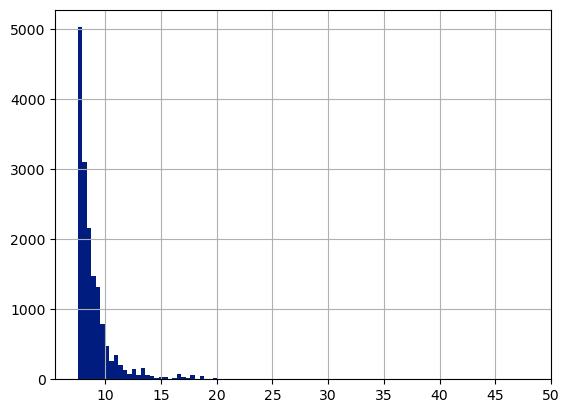

In [66]:
highs[highs['height'] > highs['threex_minside']].height_over_area.describe() 

count    5866.000000
mean        0.486242
std         0.500822
min         0.042525
25%         0.272441
50%         0.364112
75%         0.507411
max         8.333333
Name: height_over_area, dtype: float64

In [62]:
h_ratio[h_ratio['height'] > h_ratio['threex_minside']]

premise_age  premise_year  premise_use                  premise_type  \
1499     1870-1918           NaN  Residential  Semi type house in multiples   
1583     1870-1918           NaN  Residential        Standard size detached   
1591     1870-1918           NaN  Residential        Standard size detached   
1592     1870-1918           NaN  Residential        Standard size detached   
12278    1870-1918           NaN  Residential        Standard size detached   
...            ...           ...          ...                           ...   
725065   1837-1869           NaN  Residential   Standard size semi detached   
725072   1837-1869           NaN  Residential   Standard size semi detached   
725269   1960-1979           NaN  Residential     Tall terraces 3-4 storeys   
725428   1837-1869           NaN  Residential   Standard size semi detached   
725450   1837-1869           NaN  Residential           Large semi detached   

       premise_floor_count     height  premise_area  building_area  \
1499                     2  16.400000     11.400000     748.599976   
1583                     2  17.000000     11.300000     745.299988   
1591                     2  18.299999     17.100000     152.100006   
1592                     2  18.299999     30.799999     152.100006   
12278                    2  15.100000     25.900000    1196.300049   
...                    ...        ...           ...            ...   
725065                   2  17.200001     19.100000     514.599976   
725072                   2  15.200000     10.100000     124.500000   
725269                   3  27.799999     20.000000    3709.600098   
725428                   2  15.300000     17.700001     486.600006   
725450                   2  15.300000     21.900000     190.100006   

        address_area  gross_area  ... heated_vol_inc_basement_FGA  \
1499             NaN   22.799999  ...                   52.439998   
1583             NaN   22.600000  ...                   51.980001   
1591             NaN   34.200001  ...                   78.660002   
1592             NaN   61.599998  ...                  141.679996   
12278            NaN   51.799999  ...                  119.139998   
...              ...         ...  ...                         ...   
725065           NaN   38.200001  ...                  133.700003   
725072           NaN   20.200001  ...                   70.700003   
725269           NaN   60.000000  ...                  138.000000   
725428           NaN   35.400002  ...                  123.900005   
725450           NaN   43.799999  ...                  153.299997   

       avfloorheight  num_height  num_floors  av_fl_height  \
1499        8.200000   16.400000         2.0      8.200000   
1583        8.500000   17.000000         2.0      8.500000   
1591        9.150000   18.299999         2.0      9.150000   
1592        9.150000   18.299999         2.0      9.150000   
12278       7.550000   15.100000         2.0      7.550000   
...              ...         ...         ...           ...   
725065      8.600000   17.200001         2.0      8.600000   
725072      7.600000   15.200000         2.0      7.600000   
725269      9.266666   27.799999         3.0      9.266666   
725428      7.650000   15.300000         2.0      7.650000   
725450      7.650000   15.300000         2.0      7.650000   

        validated_ptype_floor_count validated_av_fl_height height_over_area  \
1499                            2.0               8.200000         1.438597   
1583                            2.0               8.500000         1.504425   
1591                            2.0               9.150000         1.070175   
1592                            2.0               9.150000         0.594156   
12278                           2.0               7.550000         0.583012   
...                             ...                    ...              ...   
725065                          2.0               8.600000         0.900524   
725072     

In [50]:
highs[highs['height_over_area'] >1  ].iloc[0:1]
# .geometry.centroid.iloc[0:1].to_crs(epsg=4326)

premise_age  premise_year  premise_use                  premise_type  \
1499   1870-1918           NaN  Residential  Semi type house in multiples   

     premise_floor_count  height  premise_area  building_area  address_area  \
1499                   2    16.4          11.4     748.599976           NaN   

      gross_area  ... heated_vol_FGA heated_vol_inc_basement_EA_FGA  \
1499   22.799999  ...      52.439998                      52.439998   

      heated_vol_inc_basement_FGA  avfloorheight  num_height  num_floors  \
1499                    52.439998            8.2        16.4         2.0   

     av_fl_height validated_ptype_floor_count validated_av_fl_height  \
1499          8.2                         2.0                    8.2   

     height_over_area  
1499         1.438597  

[1 rows x 64 columns]

In [30]:
( len( test[test['validated_av_fl_height']< 2.5]) + len(test[test['validated_av_fl_height']> 7.5]))  / len(test) * 100 

4.857737406050189

In [34]:
len( test[test['validated_av_fl_height'] > 5 ][test['validated_av_fl_height']< 7.5]) / len(test) * 100 

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


41.76185985811539

In [366]:
len(res[res['avfloorheight']==1.5][res['height']==3][res['uprn_count']==0]) / len(res) * 100

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


1.9362633569220629

In [367]:
res[res['avfloorheight']==1.5][res['height']==3][res['uprn_count']==0].premise_type.value_counts()

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


Semi type house in multiples                4653
Small low terraces                          2883
Standard size semi detached                 2669
2 storeys terraces with t rear extension     986
Standard size detached                       795
Large semi detached                          165
Large detached                               140
Planned balanced mixed estates                21
Linked and step linked premises               13
Very large detached                            1
Name: premise_type, dtype: int64

In [377]:
len(res)

637310

In [ ]:
# find rows with issues of floor size 

test[test['']]

In [383]:
import matplotlib.pyplot as plt 
plt.style.use("seaborn-dark-palette")

/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_3101/420538285.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-dark-palette")


/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key 

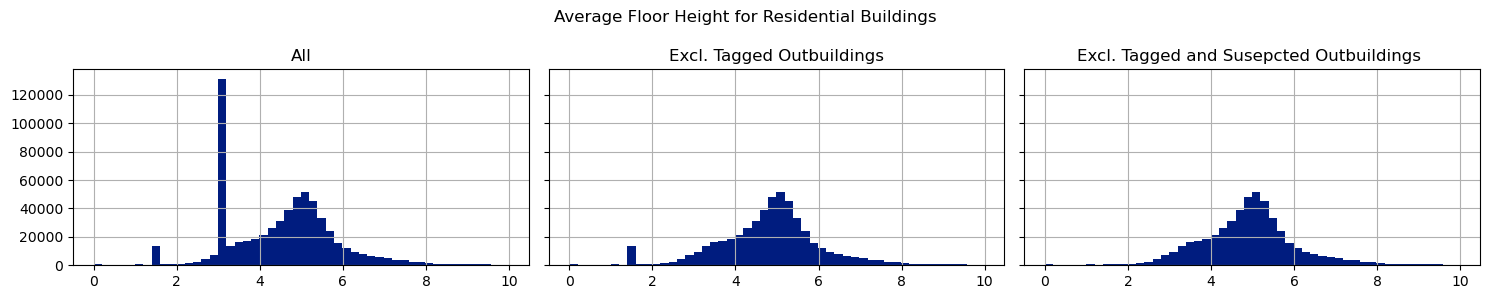

In [388]:
fig, ax = plt.subplots(ncols=3, figsize = (15,3), sharey = True )
ax=ax.ravel()

res[res['avfloorheight'] < 10].avfloorheight.hist(bins=50, ax=ax[0])
ax[0].set_title('All')

res[res['avfloorheight'] < 10][res['premise_type']!='Domestic outbuilding'].avfloorheight.hist(bins=50, ax=ax[1])
ax[1].set_title('Excl. Tagged Outbuildings')


sus_ob = res[res['avfloorheight']==1.5][res['height']==3][res['uprn_count']==0].copy() 
res[res['avfloorheight'] < 10][res['premise_type']!='Domestic outbuilding'][~res['upn'].isin(sus_ob.upn.tolist() ) ].avfloorheight.hist(bins=50, ax=ax[2])
ax[2].set_title('Excl. Tagged and Susepcted Outbuildings ')

fig.suptitle('Average Floor Height for Residential Buildings')
plt.tight_layout() 

fig.savefig('/Users/gracecolverd/New_dataset/figs/res_avfloorheight.png', bbox_inches='tight') 

In [432]:
test['av_fl_height'].describe()

count    502450.000000
mean          4.944179
std           1.329723
min           0.000000
25%           4.250000
50%           4.950000
75%           5.500000
max          89.800003
Name: av_fl_height, dtype: float64

<AxesSubplot: >

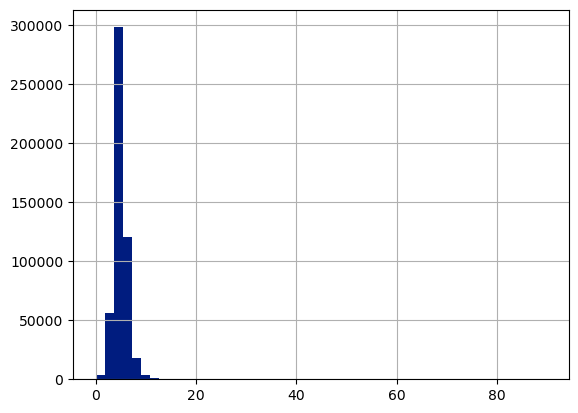

In [434]:
test['av_fl_height'].hist(bins=50)

<AxesSubplot: >

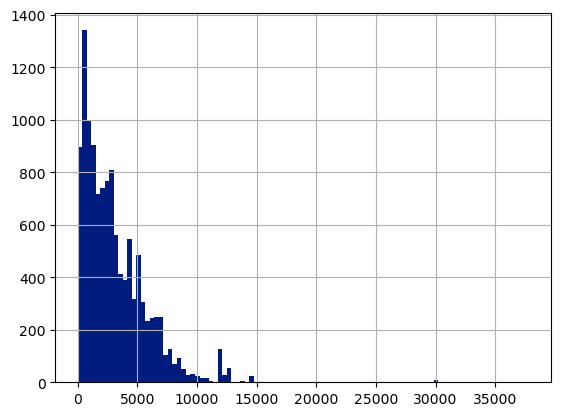

In [453]:
test[test['height']>20].building_area.hist(bins=100)

In [454]:
test[test['height']>20].building_area.describe()

count    11960.000000
mean      3129.020568
std       2720.716801
min         19.600000
25%       1038.875031
50%       2490.300049
75%       4448.500000
max      37802.699219
Name: building_area, dtype: float64

In [458]:
len(test[test['height']>20])

11960

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


<AxesSubplot: >

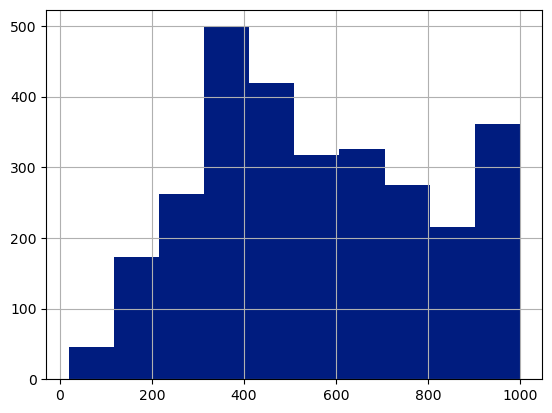

In [461]:
test[test['height']>20][test['building_area']< 1000].building_area.hist()

In [471]:
test[test['height']>20][test['building_area']< 50].iloc[1:2].upn
# .geometry.centroid.to_crs(epsg=4326)

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


642930    23500471
Name: upn, dtype: int64

In [436]:
test.head()

premise_age  premise_year  premise_use  \
0   1870-1918           NaN  Residential   
1   1870-1918           NaN  Residential   
2   1870-1918           NaN  Residential   
3   1870-1918           NaN  Residential   
4   1870-1918           NaN  Residential   

                               premise_type premise_floor_count  height  \
0  2 storeys terraces with t rear extension                   2    10.7   
1  2 storeys terraces with t rear extension                   2    10.7   
2  2 storeys terraces with t rear extension                   2    10.7   
3  2 storeys terraces with t rear extension                   2    10.7   
4               Standard size semi detached                   2    10.7   

   premise_area  building_area  address_area  gross_area  ...  \
0    130.399994    2265.699951    130.399994  260.799988  ...   
1     26.500000    2265.699951           NaN   53.000000  ...   
2     95.400002    2265.699951     63.599998  190.800003  ...   
3     54.099998    2265.699951    108.199997  108.199997  ...   
4     55.900002    2265.699951    111.800003  111.800003  ...   

  heated_vol_EA_FGA heated_vol_FGA  heated_vol_inc_basement_EA_FGA  \
0        599.839972     599.839972                      912.799957   
1        121.900000     121.900000                      121.900000   
2        438.840007     438.840007                      667.800011   
3        248.859993     248.859993                      248.859993   
4        257.140007     257.140007                      257.140007   

   heated_vol_inc_basement_FGA  avfloorheight  num_height num_floors  \
0                   912.799957           5.35        10.7        2.0   
1                   121.900000           5.35        10.7        2.0   
2                   667.800011           5.35        10.7        2.0   
3                   248.859993           5.35        10.7        2.0   
4                   257.140007           5.35        10.7        2.0   

  av_fl_height validated_floor_count validated_av_fl_height  
0         5.35                   2.0                   5.35  
1         5.35                   2.0                   5.35  
2         5.35                   2.0                   5.35  
3         5.35                   2.0                   5.35  
4         5.35                   2.0                   5.35  

[5 rows x 63 columns]

In [474]:
test.building_area

0         2265.699951
1         2265.699951
2         2265.699951
3         2265.699951
4         2265.699951
             ...     
725791    4459.700195
725798    4459.700195
725801    4459.700195
725803    4289.399902
725809     412.500000
Name: building_area, Length: 502662, dtype: float64

In [492]:
test['height_area_ratio'] = test['height'] / test['premise_area']

In [493]:
test.height_area_ratio.describe()

count    502662.000000
mean          0.181182
std           0.141711
min           0.000000
25%           0.115165
50%           0.157393
75%           0.207496
max           8.333333
Name: height_area_ratio, dtype: float64

<AxesSubplot: >

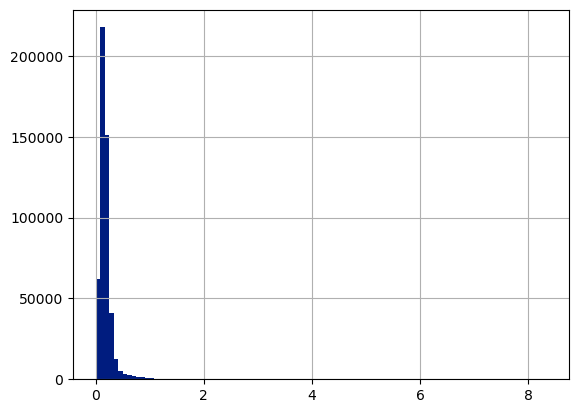

In [495]:
(test).height_area_ratio.hist(bins=100)

In [509]:
test[test['height_area_ratio']>1].iloc[1:2].geometry.centroid.to_crs(epsg=4326) 

1499    POINT (0.02572 51.54906)
dtype: geometry

In [507]:
test

from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
import numpy as np

polygon = test.geometry.iloc[0] 

def min_side(polygon):

    # Minimum rotated rectangle
    min_rect = polygon.minimum_rotated_rectangle

    # Extract the points of the rectangle to calculate side lengths
    x, y = min_rect.exterior.coords.xy

    # Calculate distances between consecutive points (sides of the rectangle)
    distances = [np.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2) for i in range(1, len(x))]

    # The least width is the minimum side length of the rectangle
    least_width = min(distances)
    return least_width 

    # print("Approximate least width:", least_width)


In [508]:
test['min_side_length'] = test.apply(lambda x: min_side(x.geometry), axis=1)


0         11.882343
1          3.951301
2          6.148576
3          6.534319
4          7.237549
            ...    
725791     5.128623
725798     3.957799
725801     5.010636
725803    13.172327
725809    11.208153
Length: 502662, dtype: float64

/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_3101/3538648875.py:12: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  x1,y2 = polygon[0].exterior.coords.xy


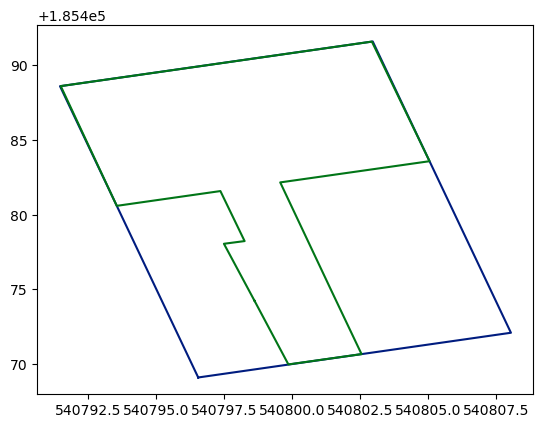

In [505]:
f, ax = plt.subplots() 
polygon = test.geometry.iloc[0] 

# Minimum rotated rectangle
min_rect = polygon.minimum_rotated_rectangle

# Extract the points of the rectangle to calculate side lengths
x, y = min_rect.exterior.coords.xy
# plot poltgon on axes 
ax.plot(x, y)

x1,y2 = polygon[0].exterior.coords.xy 

ax.plot(x1, y2)


In [506]:
build.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot: >

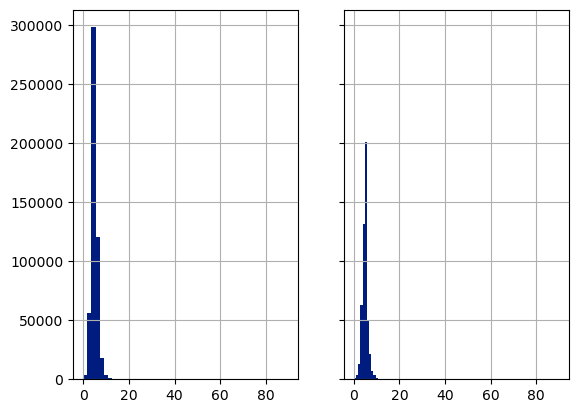

In [440]:
fig, ax = plt.subplots(ncols = 2, sharey=True, sharex=True)
ax=ax.ravel() 


test.av_fl_height.hist(bins=50,ax=ax[0]) 

test.validated_av_fl_height.hist(bins=50,ax=ax[1]) 


In [441]:
test.validated_av_fl_height.describe()

count    499599.000000
mean          4.951832
std           1.321846
min           0.000000
25%           4.250000
50%           4.950000
75%           5.500000
max          48.000000
Name: validated_av_fl_height, dtype: float64

In [447]:
test[test['validated_av_fl_height']>6].iloc[0:1].upn
# .geometry.centroid.to_crs(epsg=4326)

8    41925315
Name: upn, dtype: int64

In [448]:
test.groupby(['premise_type', 'height_bucket'] )['av_fl_height'].agg(['mean', 'count'] ).reset_index().to_csv('av_height.csv') 

In [405]:
test[test['premise_type']=='2 storeys terraces with t rear extension'].num_floors.describe()

count    114233.000000
mean          2.000061
std           0.007828
min           2.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: num_floors, dtype: float64

In [408]:
test[test['premise_type']=='2 storeys terraces with t rear extension'].height.describe()

count    114233.000000
mean         11.012537
std           1.829197
min           3.100000
25%           9.900000
50%          10.600000
75%          11.600000
max          25.500000
Name: height, dtype: float64

In [416]:
test[test['premise_type']=='2 storeys terraces with t rear extension'][test['height']>15].iloc[-1:]
# .geometry.centroid.to_crs(4326)

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


premise_age  premise_year  premise_use  \
718701   1837-1869           NaN  Residential   

                                    premise_type premise_floor_count  height  \
718701  2 storeys terraces with t rear extension                   2    18.4   

        premise_area  building_area  address_area  gross_area  ... base_floor  \
718701     61.400002         5836.5     40.900002  122.800003  ...          1   

       build_vol_inc_basement_FGA  heated_vol_EA_FGA  heated_vol_FGA  \
718701                1277.120008         282.440007      282.440007   

        heated_vol_inc_basement_EA_FGA  heated_vol_inc_basement_FGA  \
718701                      429.800011                   429.800011   

       avfloorheight num_height num_floors av_fl_height  
718701           9.2       18.4        2.0          9.2  

[1 rows x 61 columns]

In [415]:
test.premise_type.unique()

array(['2 storeys terraces with t rear extension',
       'Standard size semi detached', 'Large semi detached',
       'Small low terraces', 'Domestic outbuilding',
       'Standard size detached', '3-4 storey and smaller flats',
       'Large detached', 'Tall terraces 3-4 storeys',
       'Very tall point block flats', 'Semi type house in multiples',
       'Very large detached', 'Tall flats 6-15 storeys',
       'Linked and step linked premises', None,
       'Medium height flats 5-6 storeys',
       'Planned balanced mixed estates'], dtype=object)

<AxesSubplot: >

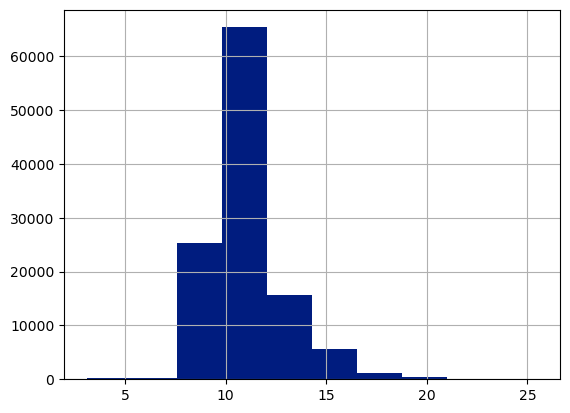

In [407]:
test[test['premise_type']=='2 storeys terraces with t rear extension'].height.hist()

In [397]:
test[test['height_bucket']=='30-40m'][test['num_floors']<8 ].iloc[0:1]

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


premise_age  premise_year  premise_use                  premise_type  \
38629   1960-1979           NaN  Residential  3-4 storey and smaller flats   

      premise_floor_count  height  premise_area  building_area  address_area  \
38629                   4    30.6         220.5    2948.800049         126.0   

       gross_area  ... base_floor build_vol_inc_basement_FGA  \
38629       882.0  ...          0                6747.300084   

       heated_vol_EA_FGA  heated_vol_FGA  heated_vol_inc_basement_EA_FGA  \
38629             2028.6          2028.6                          2028.6   

       heated_vol_inc_basement_FGA avfloorheight num_height num_floors  \
38629                       2028.6          7.65       30.6        4.0   

      av_fl_height  
38629         7.65  

[1 rows x 61 columns]

In [396]:
test[test['height_bucket']=='30-40m'][test['num_floors']<8 ].iloc[0:1].geometry.centroid.to_crs('EPSG:4326')

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


38629    POINT (-0.16255 51.53605)
dtype: geometry

In [296]:
res[res['premise_type']=='Very tall point block flats'].avfloorheight.describe()

count    529.000000
mean       2.395277
std        0.878723
min        0.000000
25%        2.588889
50%        2.761905
75%        2.822727
max        6.333333
Name: avfloorheight, dtype: float64

In [305]:
build = gpd.read_file('/Volumes/T9/postcode_data/data/verisk_y2022_V4/bbox_529252.36_186435.25920425786_539252.36_196435.25920425786.gpkg')
total_bounds = np.array([532020., 181806., 532230., 182016.])
# total_bounds convert to bounding box 
bbox = box(total_bounds[0], total_bounds[1], total_bounds[2], total_bounds[3])   

# new data 
build = gpd.read_file('/Volumes/T9/Data_downloads/Versik_building_data/2024_03_22_updated_data/UKBuildings_Edition_15_new_format_upn.gpkg', bbox=bbox)   


In [309]:
res[res.avfloorheight >6][res['premise_floor_count']=='9'].geometry.to_crs('EPSG:4326').centroid

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_3101/1143834386.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  res[res.avfloorheight >6][res['premise_floor_count']=='9'].geometry.to_crs('EPSG:4326').centroid


654011    POINT (-0.09051 51.52367)
dtype: geometry

In [311]:
res[res.avfloorheight >6][res['premise_floor_count']=='9'].geometry.centroid.to_crs('EPSG:4326')

res[res.avfloorheight >6][res['premise_floor_count']=='9']

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


premise_age  premise_year  premise_use                 premise_type  \
654011   1960-1979           NaN  Residential  Very tall point block flats   

       premise_floor_count  height  premise_area  building_area  address_area  \
654011                   9    57.0     76.599998          602.0           NaN   

        gross_area  ... height_numeric_FGA listed_bool  build_vol_FGA  \
654011  689.400024  ...               57.0           0    4366.199913   

        base_floor  build_vol_inc_basement_FGA  heated_vol_EA_FGA  \
654011           0                 4366.199913        1585.619968   

       heated_vol_FGA heated_vol_inc_basement_EA_FGA  \
654011    1585.619968                    1585.619968   

       heated_vol_inc_basement_FGA avfloorheight  
654011                 1585.619968      6.333333  

[1 rows x 58 columns]

In [320]:
res.premise_type.unique() 

array(['2 storeys terraces with t rear extension',
       'Standard size semi detached', 'Large semi detached',
       'Small low terraces', 'Domestic outbuilding',
       'Standard size detached', '3-4 storey and smaller flats',
       'Large detached', 'Tall terraces 3-4 storeys', None,
       'Very tall point block flats', 'Semi type house in multiples',
       'Very large detached', 'Tall flats 6-15 storeys',
       'Linked and step linked premises',
       'Medium height flats 5-6 storeys',
       'Planned balanced mixed estates'], dtype=object)

In [314]:
len(res)

637310

In [325]:
import pandas as pd

# Assuming 'res' is your DataFrame and it's already defined.

# Apply the conditions and update 'premise_type'
# res.loc[(res['height'] == 3) & (res['premise_floor_count'] == '2') & (res['uprn_count'] == 0), 'premise_type'] = 'Domestic outbuilding'
import pandas as pd

# Assuming 'res' is your DataFrame and it's already defined.

# Apply the conditions with the height range and update 'premise_type'
res.loc[(res['height'].between(2.8, 3.2)) & (res['premise_floor_count'] == '2') & (res['uprn_count'] == 0), 'premise_type'] = 'Domestic outbuilding'



In [319]:
res[res['height']==3][res['premise_floor_count']=='2'][res['uprn_count']==0].iloc[10:11].geometry.centroid.to_crs('EPSG:4326')

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


1329    POINT (0.02343 51.55640)
dtype: geometry

In [261]:
res[['premise_type', 'height', 'premise_floor_count', 'avfloorheight']]

premise_type     height  \
0       2 storeys terraces with t rear extension  10.700000   
1       2 storeys terraces with t rear extension  10.700000   
2       2 storeys terraces with t rear extension  10.700000   
3       2 storeys terraces with t rear extension  10.700000   
4                    Standard size semi detached  10.700000   
...                                          ...        ...   
725798                 Tall terraces 3-4 storeys  15.600000   
725801                 Tall terraces 3-4 storeys  15.600000   
725803                 Tall terraces 3-4 storeys  20.900000   
725809                   Tall flats 6-15 storeys  24.200001   
725812                      Domestic outbuilding   3.000000   

       premise_floor_count  avfloorheight  
0                        2       5.350000  
1                        2       5.350000  
2                        2       5.350000  
3                        2       5.350000  
4                        2       5.350000  
...                    ...            ...  
725798                   3       5.200000  
725801                   3       5.200000  
725803                   3       6.966667  
725809                   8       3.025000  
725812                   1       3.000000  

[637310 rows x 4 columns]

In [130]:
res.avfloorheight.describe()

count    230866.000000
mean          4.550861
std           1.316731
min           0.000000
25%           3.033333
50%           4.800000
75%           5.350000
max          48.000000
Name: avfloorheight, dtype: float64

In [268]:
res[res['avfloorheight']>20].iloc[0:1].geometry.centroid.to_crs(epsg=4326)

res[res['avfloorheight']>20].iloc[0:1].upn

49413    43230338
Name: upn, dtype: int64

In [137]:
res[res['avfloorheight']>20].geometry.centroid.to_crs(epsg=4326)

9936      POINT (-0.04372 51.57913)
9937      POINT (-0.04348 51.57916)
9938      POINT (-0.04330 51.57919)
71578     POINT (-0.09401 51.56885)
71579     POINT (-0.09371 51.56920)
102629    POINT (-0.07376 51.58546)
dtype: geometry

In [116]:
# split column by comma 
build['premise_floor_count'].str.split(',').str[0]  

0         1
1         4
2         1
3         2
4         1
         ..
255435    3
255436    3
255437    2
255438    2
255439    3
Name: premise_floor_count, Length: 255440, dtype: object

In [6]:
build.premise_age.unique()

array(['1980-1989', '1945-1959,1980-1989', 'Post 1999', 'Unknown date',
       '1960-1979', '1945-1959', '1919-1944', 'Pre 1919', '1837-1869',
       '1990-1999', '1870-1918', '1945-1959,Unknown date',
       '1919-1944,1980-1989', '1980-1989,Pre 1919,Unknown date',
       '1980-1989,Unknown date', 'Pre 1837', '1945-1959,Pre 1919',
       '1919-1944,1945-1959,Pre 1919', '1945-1959,1980-1989,Pre 1919',
       '1980-1989,Pre 1919', '1919-1944,1945-1959', '1919-1944,Pre 1919',
       'Pre 1919,Unknown date', '1919-1944,1945-1959,1980-1989',
       '1945-1959,1980-1989,Unknown date',
       '1919-1944,Pre 1919,Unknown date',
       '1919-1944,1945-1959,1980-1989,Pre 1919', '1919-1944,Unknown date',
       '1945-1959,1980-1989,Pre 1919,Unknown date',
       '1919-1944,1945-1959,1980-1989,Unknown date',
       '1919-1944,1945-1959,1980-1989,Pre 1919,Unknown date',
       '1919-1944,1945-1959,Unknown date',
       '1919-1944,1945-1959,Pre 1919,Unknown date',
       '1919-1944,1980-1989,Pre 19

In [8]:
build[build['premise_use']=='Residential'].premise_type.unique()

array(['Medium height flats 5-6 storeys', 'Small low terraces',
       '3-4 storey and smaller flats', 'Domestic outbuilding',
       'Tall terraces 3-4 storeys', 'Large semi detached',
       'Standard size detached', 'Standard size semi detached',
       '2 storeys terraces with t rear extension',
       'Semi type house in multiples', 'Tall flats 6-15 storeys',
       'Large detached', 'Very tall point block flats',
       'Very large detached', None, 'Planned balanced mixed estates',
       'Linked and step linked premises'], dtype=object)

In [6]:
build[build['map_simple_use']=='Residential'].premise_age.unique()  

array(['1980-1989', 'Post 1999', '1960-1979', 'Unknown date', '1945-1959',
       '1837-1869', '1990-1999', '1870-1918', '1919-1944', 'Pre 1837',
       'Pre 1919'], dtype=object)

In [17]:
data.premise_type.unique()

array(['Medium height flats 5-6 storeys', 'Small low terraces',
       '3-4 storey and smaller flats', 'Domestic outbuilding',
       'Tall terraces 3-4 storeys', 'Large semi detached',
       'Standard size detached', 'Standard size semi detached',
       '2 storeys terraces with t rear extension',
       'Semi type house in multiples', 'Tall flats 6-15 storeys',
       'Large detached', 'Very tall point block flats',
       'Very large detached', None, 'Planned balanced mixed estates',
       'Linked and step linked premises'], dtype=object)

In [213]:
data = build[build['premise_use']=='Residential'].copy()
data = data[~data['premise_type'].isna()].copy()
data=data[ data['height']!=0].copy() 
data['avfloor_height'] = data['height'] / data['premise_floor_count'].astype(float)

data[['premise_type', 'premise_floor_count']].drop_duplicates()

premise_type premise_floor_count
1                   3-4 storey and smaller flats                   4
9                Medium height flats 5-6 storeys                   6
14                            Small low terraces                   2
24                          Domestic outbuilding                   1
25               Medium height flats 5-6 storeys                   5
33                     Tall terraces 3-4 storeys                   4
46                   Standard size semi detached                   2
55                  3-4 storey and smaller flats                   3
57                     Tall terraces 3-4 storeys                   3
189                    Tall terraces 3-4 storeys                   5
326     2 storeys terraces with t rear extension                   2
445                          Large semi detached                   3
544                       Standard size detached                   2
903                 Semi type house in multiples                   2
1067                     Tall flats 6-15 storeys                   7
1350                   Tall terraces 3-4 storeys                   6
1624                     Tall flats 6-15 storeys                   8
1754                     Tall flats 6-15 storeys                   9
1757                         Large semi detached                   2
2071                              Large detached                   2
2652                 Very tall point block flats                  10
4449                     Tall flats 6-15 storeys                  10
4980                 Very tall point block flats                  15
5741                 Very tall point block flats                  14
6008                 Very tall point block flats                  11
8859                         Very large detached                   3
11515                    Tall flats 6-15 storeys                  11
11521                    Tall flats 6-15 storeys                  30
11522                    Tall flats 6-15 storeys                  34
11524                Very tall point block flats                  30
11540                Very tall point block flats                  34
13834                Very tall point block flats                  17
14026                    Tall flats 6-15 storeys                  13
14031                Very tall point block flats                  13
18266                         Small low terraces                   1
20828                        Very large detached                   4
23195             Planned balanced mixed estates                   2
43843                Very tall point block flats                  12
53258               3-4 storey and smaller flats                   5
53273               3-4 storey and smaller flats                   6
53290                Very tall point block flats                  22
65138            Linked and step linked premises                   2
67464                Very tall point block flats                  16
72339                    Tall flats 6-15 storeys                  12
72577                Very tall point block flats                  20
72708                    Tall flats 6-15 storeys                  20
77954                Very tall point block flats                  19
95689                Very tall point block flats                  18
106777                   Tall flats 6-15 storeys                  51
124779              3-4 storey and smaller flats                   2
157474                   Tall flats 6-15 storeys                  19
184977                       Very large detached                   2
218349               Very tall point block flats                  23

range(3, 6)
4
range(5, 7)
6
range(5, 7)
6
[1, 2, 3, 4]
2
[1, 2, 3, 4]
2
range(3, 6)
4
[1, 2, 3, 4]
2
[1, 2, 3, 4]
2
[1, 2, 3, 4]
2
[1, 2, 3, 4]
2
[1, 2, 3, 4]
2
[1, 2, 3, 4]
2
[1, 2, 3, 4]
2
[1, 2, 3]
1
range(5, 7)
5
range(3, 6)
4
[1, 2, 3]
2
[1, 2, 3]
2
[1, 2, 3]
2
[1, 2, 3]
2
[1, 2, 3]
2
[1, 2, 3]
2
[1, 2, 3]
2
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
[1, 2, 3]
1
range(3, 6)
3
range(3, 6)
4
range(3, 6)
3
range(3, 6)
4
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
4
range(3, 6)
4
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
range(3, 6)
3
r

In [215]:
data[data['premise_type']=='Very tall point block flats'].height.describe()  
# [data['premise_use']=='Residential']
# [data['premise_floor_count'] =='1' ]


count    88.000000
mean     36.104545
std      18.515305
min       3.000000
25%      25.975000
50%      36.000000
75%      46.275001
max      94.400002
Name: height, dtype: float64

In [183]:
data.columns

Index(['premise_age', 'premise_year', 'premise_use', 'premise_type',
       'premise_floor_count', 'height', 'premise_area', 'building_area',
       'address_area', 'gross_area', 'basement', 'listed_grade',
       'element_count', 'bathroom_count', 'bedroom_count',
       'reception_room_count', 'roof_type', 'wall_type', 'substructure_type',
       'glazing_type', 'wall_construction_type', 'extension_count',
       'habitable_rooms', 'open_fireplaces', 'floor_type', 'distance_building',
       'site_id', 'site_area', 'site_non_built_area', 'site_building_count',
       'distance_water', 'verisk_building_id', 'uprn', 'uprn_count',
       'uprn_distance', 'toid', 'map_age', 'map_floors', 'map_use',
       'map_simple_use', 'upn', 'geometry', 'avfloor_height',
       'validated_floor_count'],
      dtype='object')

In [233]:
data[data['avfloor_height']==1.5 ].premise_type.value_counts()
# .iloc[100:101].geometry.centroid.to_crs(epsg=4326)

# data[data['avfloor_height']< 2].iloc[100:101].upn

Semi type house in multiples                2544
Small low terraces                          1263
Standard size semi detached                 1007
2 storeys terraces with t rear extension     376
Standard size detached                       292
Large semi detached                           54
Large detached                                19
3-4 storey and smaller flats                   5
Planned balanced mixed estates                 2
Name: premise_type, dtype: int64

In [236]:
data[data['avfloor_height']==1.5 ].iloc[0:1].geometry.centroid.to_crs(epsg=4326)

# data[data['avfloor_height']< 2].iloc[100:101].upn

1914    POINT (-0.08893 51.56554)
dtype: geometry

In [244]:
data[data['avfloor_height']==1.5 ].premise_type.value_counts()

Semi type house in multiples                2544
Small low terraces                          1263
Standard size semi detached                 1007
2 storeys terraces with t rear extension     376
Standard size detached                       292
Large semi detached                           54
Large detached                                19
3-4 storey and smaller flats                   5
Planned balanced mixed estates                 2
Name: premise_type, dtype: int64

In [181]:
data[data['premise_type']=='Very tall point block flats'][data['height']<10].iloc[0:1].geometry.centroid.to_crs(epsg=4326)

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


4988    POINT (-0.05338 51.56691)
dtype: geometry

In [89]:
tt = data[data['premise_type']=='Very tall point block flats'].copy() 

In [90]:
tt['premise_floor_count'].unique()

array(['10', '15', '14', '11', '30', '34', '17', '13', '12', '22', '16',
       '20', '19', '18', '23'], dtype=object)

In [105]:
build.columns

Index(['premise_age', 'premise_year', 'premise_use', 'premise_type',
       'premise_floor_count', 'height', 'premise_area', 'building_area',
       'address_area', 'gross_area', 'basement', 'listed_grade',
       'element_count', 'bathroom_count', 'bedroom_count',
       'reception_room_count', 'roof_type', 'wall_type', 'substructure_type',
       'glazing_type', 'wall_construction_type', 'extension_count',
       'habitable_rooms', 'open_fireplaces', 'floor_type', 'distance_building',
       'site_id', 'site_area', 'site_non_built_area', 'site_building_count',
       'distance_water', 'verisk_building_id', 'uprn', 'uprn_count',
       'uprn_distance', 'toid', 'map_age', 'map_floors', 'map_use',
       'map_simple_use', 'geometry'],
      dtype='object')

In [104]:
from src.pre_process_buildings import pre_process_building_data 

data = pre_process_building_data(data)   

KeyError: 'upn'

In [91]:
tt['height'].describe()

count    88.000000
mean     36.104545
std      18.515305
min       3.000000
25%      25.975000
50%      36.000000
75%      46.275000
max      94.400000
Name: height, dtype: float64

In [102]:
tt[tt['premise_floor_count']=='10'].iloc[2:3]
# .geometry.centroid.to_crs('EPSG:4326')

premise_age  premise_year  premise_use                 premise_type  \
70315   1960-1979           NaN  Residential  Very tall point block flats   

      premise_floor_count  height  premise_area  building_area  address_area  \
70315                  10    26.6         382.9          382.9         100.8   

       gross_area  ...          uprn uprn_count  uprn_distance  \
70315      3829.0  ...  5.300072e+09         38            0.0   

                    toid    map_age  map_floors      map_use map_simple_use  \
70315  osgb1000005442695  1960-1979          10  Residential    Residential   

                                                geometry validated_floor_count  
70315  MULTIPOLYGON (((529626.270 186662.990, 529620....                   NaN  

[1 rows x 42 columns]

2.79

In [80]:
tt[tt['height'] > 20].iloc[130:132].geometry.centroid.to_crs('EPSG:4326')

74234    POINT (-0.11691 51.56990)
74235    POINT (-0.11685 51.56993)
dtype: geometry

In [60]:
tt[tt['height'] > 20].iloc[141:].geometry.centroid.to_crs('EPSG:4326')

74357    POINT (-0.11719 51.57046)
74360    POINT (-0.11713 51.57049)
74364    POINT (-0.11707 51.57052)
74367    POINT (-0.11700 51.57055)
dtype: geometry

In [ ]:

Medium height flats 5-6 storeys	

Tall flats 6-15 storeys

In [8]:
build.groupby('premise_type')

['Medium height flats 5-6 storeys',
 None,
 'Small low terraces',
 '3-4 storey and smaller flats',
 'Domestic outbuilding',
 'Tall terraces 3-4 storeys',
 'Large semi detached',
 'Standard size detached',
 'Standard size semi detached',
 '2 storeys terraces with t rear extension',
 'Semi type house in multiples',
 'Tall flats 6-15 storeys',
 'Large detached',
 'Very tall point block flats',
 'Very large detached',
 'Planned balanced mixed estates',
 'Linked and step linked premises']

In [7]:
one_hot = pd.get_dummies(build['premise_type'])
build2 = pd.concat([build, one_hot], axis=1)


In [26]:
import pandas as pd
from scipy.stats import mode

# Assuming 'build' is your DataFrame
# Define a custom aggregation function that returns the first mode in case of multiple modes
def agg_mode(x):
    # check if multiple modes 
    # if len(mode(x).mode) > 1:
    #     # return the first mode
    #     print('multiple modes found') 
    return mode(x).mode[0]

# Use the custom function with groupby. Note that 'apply' is used to accommodate custom logic
mode_result = build.groupby(['premise_use', 'premise_type'])['premise_age'].apply(agg_mode).reset_index(name='mode_age')

print(mode_result)


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_25760/1358165263.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return mode(x).mode[0]
/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_25760/1358165263.py:11: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.Data

               premise_use                  premise_type   mode_age
0   Commercial - mixed use  3-4 storey and smaller flats  1945-1959
1   Commercial - mixed use            Small low terraces   Pre 1919
2   Commercial - mixed use        Standard size detached   Pre 1919
3   Commercial - mixed use   Standard size semi detached  1919-1944
4   Commercial - mixed use     Tall terraces 3-4 storeys  1945-1959
..                     ...                           ...        ...
78            Unclassified     Tall terraces 3-4 storeys  1980-1989
79               Utilities  3-4 storey and smaller flats  1919-1944
80               Utilities            Small low terraces  1945-1959
81               Utilities        Standard size detached  1945-1959
82               Utilities   Standard size semi detached  1980-1989

[83 rows x 3 columns]


In [14]:
build.groupby(['map_simple_use', 'premise_age', 'premise_floor_count'])['height'].mean()

map_simple_use  premise_age   premise_floor_count
Mixed Use       1870-1918     3                      14.050000
                1919-1944     1                       9.660000
                              1,2                    12.400000
                              1,3                     8.900000
                              2                      10.636235
                                                       ...    
Residential     Pre 1919      3                       8.287500
                              4                      12.266667
                              5                      15.200000
                Unknown date  1                       3.000034
                              2                       3.000000
Name: height, Length: 463, dtype: float64

In [ ]:

# Compute the weighted average
weighted_avg = aggregated_stats.div(weights['count'], axis=0)

In [29]:
def one_hot_encode_premise_type(df):
    pre_cols = df.columns.tolist()
    one_hot = pd.get_dummies(df['premise_type'], 'premusetype')
    df = pd.concat([df, one_hot], axis=1)
    post_cols = df.columns.tolist()
    new_cols = [col for col in post_cols if col not in pre_cols]
    return df, new_cols 

In [30]:
df, n = one_hot_encode_premise_type(build)

In [33]:
ll = open('/Users/gracecolverd/New_dataset/old/testing/batches/EE/batch_9.txt', 'r')

In [15]:
pre = build.columns.tolist()
post = build2.columns.tolist()
# cols to sum : 
cols_to_sum = [x for x in post if x not in pre]
cols_to_sum

['2 storeys terraces with t rear extension',
 '3-4 storey and smaller flats',
 'Domestic outbuilding',
 'Large detached',
 'Large semi detached',
 'Linked and step linked premises',
 'Medium height flats 5-6 storeys',
 'Planned balanced mixed estates',
 'Semi type house in multiples',
 'Small low terraces',
 'Standard size detached',
 'Standard size semi detached',
 'Tall flats 6-15 storeys',
 'Tall terraces 3-4 storeys',
 'Very large detached',
 'Very tall point block flats']

In [17]:
# sum cols
build2[cols_to_sum].sum()

2 storeys terraces with t rear extension    55407
3-4 storey and smaller flats                 6460
Domestic outbuilding                        46760
Large detached                                249
Large semi detached                          3137
Linked and step linked premises                31
Medium height flats 5-6 storeys               497
Planned balanced mixed estates                157
Semi type house in multiples                27874
Small low terraces                          40372
Standard size detached                       5678
Standard size semi detached                 30352
Tall flats 6-15 storeys                        87
Tall terraces 3-4 storeys                    8046
Very large detached                             8
Very tall point block flats                    89
dtype: int64

In [ ]:
building_groupings = {
    "Low-Rise Residential": [
        "Small low terraces",
        "Domestic outbuilding",
        "Standard size semi-detached",
        "Standard size detached",
        "Large semi-detached",
        "2 storeys terraces with t rear extension"
         "Very large detached", 
          "Large detached",
    ],
    "Medium-Rise Residential": [
        "Medium height flats 5-6 storeys",
        "3-4 storey and smaller flats",
        "Tall terraces 3-4 storeys",
        "Semi-type house in multiples"
    ],
    "High-Rise Residential": [
        "Tall flats 6-15 storeys",
        "Very tall point block flats",
       
    ],
    "Special Categories": [
        "Large detached",
        "Planned balanced mixed estates",
        "Linked and step linked premises"
    ]
}

print(building_groupings)


In [151]:
build[build['premise_floor_count'] =='1,2'].to_csv('test_builds.csv')

In [152]:
build['height'].describe() 

count    248585.000000
mean          8.908354
std           4.127153
min           0.000000
25%           5.800000
50%           9.900000
75%          11.000000
max         142.700000
Name: height, dtype: float64

In [20]:
build[build['height']==0].premise_age.value_counts()


Post 1999       7055
Unknown date    2918
1870-1918        914
1919-1944        824
1945-1959        352
1960-1979        307
1990-1999        173
1980-1989        172
Pre 1919          95
Pre 1837          13
1837-1869          8
Name: premise_age, dtype: int64

In [24]:
df = build
df['premise_age_bucketed'] = np.where(df['premise_age'].isin(['Pre 1837', '1837-1869', '1870-1918']), 'Pre 1919', df['premise_age']) 

In [28]:
df.premise_age_bucketed.unique()

array(['Unknown date', 'Pre 1919', '1919-1944', '1960-1979', '1980-1989',
       'Post 1999', '1945-1959', '1990-1999', '1945-1959,Pre 1919',
       '1980-1989,Pre 1919', '1945-1959,Post 1999',
       '1945-1959,Unknown date', '1960-1979,Unknown date',
       '1945-1959,1980-1989,Unknown date', '1980-1989,Unknown date',
       '1919-1944,Pre 1919', '1945-1959,1980-1989',
       '1945-1959,1980-1989,Pre 1919', '1919-1944,1945-1959',
       '1919-1944,1980-1989', '1919-1944,1945-1959,1990-1999',
       '1919-1944,1960-1979', '1990-1999,Pre 1919',
       'Post 1999,Unknown date', '1945-1959,Post 1999,Unknown date',
       '1990-1999,Unknown date', '1919-1944,Unknown date',
       'Pre 1919,Unknown date', '1945-1959,Pre 1919,Unknown date',
       '1945-1959,1990-1999', '1919-1944,1945-1959,1980-1989',
       '1945-1959,1990-1999,Pre 1919', '1990-1999,Pre 1919,Unknown date',
       '1919-1944,Post 1999', '1919-1944,1945-1959,Pre 1919',
       '1919-1944,1990-1999,Pre 1919', '1919-1944,Pre 1

In [40]:

def get_val_from_age_band(row):
    age_band = row['premise_age']
    if age_band == 'Pre 1919':
        val = 3
    elif age_band == '1919-1944':
        val = 2.9
    elif age_band == '1945-1959':
        val = 2.8
    elif age_band == '1960-1979':
        val = 2.2
    elif age_band == '1980-1989':
        val = 2.2
    elif age_band == '1990-1999':
        val = 2.2
    elif age_band == 'Post 1999':
        val = 2.4
    else:
        val = 2.3
    return val

    # Use this function to get the 'val' based on 'age_band'
    # val = get_val_from_age_band(age_band)

def fill_missing_height(df):
    for index, row in df.iterrows():
            if row['height'] == 0:
                val = get_val_from_age_band(row)
                df.at[index, 'height'] = (int(row['premise_floor_count']) * val) * 1.15 

    return df

In [79]:
df = build[build['premise_use']=='Residential'].copy() 

In [54]:
df.columns

Index(['premise_age', 'premise_year', 'premise_use', 'premise_type',
       'premise_floor_count', 'height', 'premise_area', 'building_area',
       'address_area', 'gross_area', 'basement', 'listed_grade',
       'element_count', 'bathroom_count', 'bedroom_count',
       'reception_room_count', 'roof_type', 'wall_type', 'substructure_type',
       'glazing_type', 'wall_construction_type', 'extension_count',
       'habitable_rooms', 'open_fireplaces', 'floor_type', 'distance_building',
       'site_id', 'site_area', 'site_non_built_area', 'site_building_count',
       'distance_water', 'verisk_building_id', 'uprn', 'uprn_count',
       'uprn_distance', 'toid', 'map_age', 'map_floors', 'map_use',
       'map_simple_use', 'geometry', 'premise_age_bucketed'],
      dtype='object')

In [55]:
df.map_simple_use.value_counts()

Residential        291361
Non Residential     81177
Mixed Use            1996
Name: map_simple_use, dtype: int64

In [103]:
link = pd.read_csv('/Volumes/T9/Data_downloads/Versik_building_data/2024_03_full_building_data/6101/Data/edition_15_abc_link_file.csv') 

In [4]:
import geopandas as gpd 

df = gpd.read_file('/Volumes/T9/postcode_data/data/verisk_y2022_V5/bbox_69252.359375_816435.2583007812_79252.359375_826435.2583007812.gpkg')


In [9]:
import pandas as pd 
df = pd.read_csv('/Users/gracecolverd/New_dataset/proc/processing_log.csv', header=None) 


0  \
0     /Volumes/T9/postcode_data/data/verisk_y2022_V5...   
1     /Volumes/T9/postcode_data/data/verisk_y2022_V5...   
2     /Volumes/T9/postcode_data/data/verisk_y2022_V5...   
3     /Volumes/T9/postcode_data/data/verisk_y2022_V5...   
4     /Volumes/T9/postcode_data/data/verisk_y2022_V5...   
...                                                 ...   
1630  /Volumes/T9/postcode_data/data/verisk_y2022_V5...   
1631  /Volumes/T9/postcode_data/data/verisk_y2022_V5...   
1632  /Volumes/T9/postcode_data/data/verisk_y2022_V5...   
1633  /Volumes/T9/postcode_data/data/verisk_y2022_V5...   
1634  /Volumes/T9/postcode_data/data/verisk_y2022_V5...   

                                                      1          2  3  
0     (9252.359375, 6435.25830078125, 19252.359375, ...  completed  0  
1     (9252.359375, 16435.25830078125, 19252.359375,...  completed  0  
2     (9252.359375, 26435.25830078125, 19252.359375,...  completed  0  
3     (9252.359375, 36435.25830078125, 19252.359375,...  completed  0  
4     (9252.359375, 46435.25830078125, 19252.359375,...  completed  0  
...                                                 ...        ... ..  
1630  (139252.359375, 446435.25830078125, 149252.359...  completed  0  
1631  (139252.359375, 456435.25830078125, 149252.359...  completed  0  
1632  (139252.359375, 466435.25830078125, 149252.359...  completed  0  
1633  (139252.359375, 476435.25830078125, 149252.359...  completed  0  
1634  (139252.359375, 486435.25830078125, 149252.359...  completed  0  

[1635 rows x 4 columns]

In [19]:
import os 
import pandas as pd 
def merge_temp_logs_to_main(log_file="/Users/gracecolverd/New_dataset/proc/log2.csv"):
    """
    Merge all temporary log files created by threads into the main log file.

    Parameters:
    - log_file: str, the path to the main log file.
    """
    # Assume temp files are in the same directory as the main log file
    temp_files = [f for f in os.listdir(os.path.dirname(log_file)) if f.startswith('temp_log_') and f.endswith('.csv')]
    print('num of temp files found ', len(temp_files) ) 
    # Create or append to the main log file
    if len(temp_files) != 0:
        for temp_file in temp_files:
            temp_file_path = os.path.join(os.path.dirname(log_file), temp_file)
            df_temp = pd.read_csv(temp_file_path )
            
            if os.path.exists(log_file):
                df_temp.to_csv(log_file, mode='a', header=False, index=False)
            else:
                df_temp.to_csv(log_file, mode='w', header=True, index=False)
    print('fn complete')

In [20]:
merge_temp_logs_to_main()

num of temp files found  6
fn complete


In [23]:
df = gpd.read_file('/Volumes/T9/postcode_data/data/verisk_y2022_V5/bbox_199252.359375_786435.2583007812_209252.359375_796435.2583007812.gpkg')

In [24]:
l

premise_age  premise_year             premise_use            premise_type  \
0     1870-1918           NaN  Recreation and leisure                    None   
1  Unknown date           NaN             Residential                    None   
2  Unknown date           NaN             Residential                    None   
3  Unknown date           NaN             Residential                    None   
4  Unknown date           NaN             Residential                    None   
5     Post 1999        2000.0             Residential          Large detached   
6      Pre 1919           NaN             Residential  Standard size detached   
7  Unknown date           NaN             Residential                    None   

  premise_floor_count  height  premise_area  building_area  address_area  \
0                None    19.3          78.8           78.8           NaN   
1                   2     7.9         131.9          131.9           NaN   
2                   2     9.0          59.0           59.0           NaN   
3                   2     8.6         287.4          287.4           NaN   
4                   2     8.2         132.4          132.4           NaN   
5                   2     8.4         170.1          170.1         340.2   
6                   2     8.7         100.1          100.1         200.2   
7                   2     8.6          52.2           52.2           NaN   

   gross_area  ...         uprn uprn_count  uprn_distance               toid  \
0         NaN  ...  130167157.0          1            0.0  osgb1000039285271   
1       263.8  ...          NaN          0            NaN               None   
2       118.0  ...          NaN          0            NaN               None   
3       574.8  ...          NaN          0            NaN               None   
4       264.8  ...          NaN          0            NaN               None   
5       340.2  ...  130073603.0          1            0.0  osgb1000039285275   
6       200.2  ...  130073602.0          1            0.0  osgb1000039285274   
7       104.4  ...          NaN          0            NaN               None   

        map_age  map_floors                 map_use   map_simple_use  \
0     1870-1918        None  Recreation and leisure  Non Residential   
1  Unknown date           2             Residential      Residential   
2  Unknown date           2             Residential      Residential   
3  Unknown date           2             Residential      Residential   
4  Unknown date           2             Residential      Residential   
5     Post 1999           2             Residential      Residential   
6      Pre 1919           2             Residential      Residential   
7  Unknown date           2             Residential      Residential   

        upn                                           geometry  
0   3053015  MULTIPOLYGON (((200156.00000 796065.50000, 200...  
1  28888619  MULTIPOLYGON (((200214.18986 796114.43163, 200...  
2  28889645  MULTIPOLYGON (((203075.27780 792617.29457, 203...  
3  28889647  MULTIPOLYGON (((203320.01347 792579.51641, 203...  
4  28889709  MULTIPOLYGON (((205370.56000 792354.29000, 205...  
5   2515927  MULTIPOLYGON (((201053.50000 792316.00000, 201...  
6  22142161  MULTIPOLYGON (((206327.00000 792251.00000, 206...  
7   2493373  MULTIPOLYGON (((206325.35000 792273.54000, 206...  

[8 rows x 42 columns]

In [2]:
import pandas as pd 
df = pd.read_csv('/Users/gracecolverd/New_dataset/proc/processing_log.csv')


In [4]:
build

NameError: name 'build' is not defined

In [111]:
merg = build.merge(link, left_on = ['verisk_building_id', 'toid'],  right_on = ['ubn', 'toid' ] )

In [226]:
build.height.describe()

count    248585.000000
mean          8.908354
std           4.127153
min           0.000000
25%           5.800000
50%           9.900000
75%          11.000000
max         142.700000
Name: height, dtype: float64

In [229]:
# Convert 'premise_floor_count' to numeric, coercing errors to NaN
height_bins = [0, 2 , 4 , 6, 10, 12, 14, 18, 20, 30 , 40 ,50 , 100 ,200 ]  # Example height ranges in meters
height_labels = [f"{height_bins[i]}-{height_bins[i+1]}m" for i in range(len(height_bins)-1)]


gdf = build.copy() 
gdf['premise_floor_count'] = pd.to_numeric(gdf['premise_floor_count'], errors='coerce')
gdf

premise_age  premise_year         premise_use  \
0                 1980-1989           NaN         Residential   
1       1945-1959,1980-1989           NaN  Emergency services   
2                 Post 1999           NaN         Residential   
3              Unknown date           NaN        Unclassified   
4                 1960-1979           NaN         Residential   
...                     ...           ...                 ...   
248606         Unknown date           NaN         Residential   
248607         Unknown date           NaN         Residential   
248608         Unknown date           NaN         Residential   
248609         Unknown date           NaN         Residential   
248610         Unknown date           NaN         Residential   

                           premise_type  premise_floor_count  height  \
0       Medium height flats 5-6 storeys                  6.0    17.7   
1                                  None                  2.0     8.1   
2       Medium height flats 5-6 storeys                  6.0    12.8   
3                                  None                  NaN     4.4   
4                    Small low terraces                  2.0     7.1   
...                                 ...                  ...     ...   
248606             Domestic outbuilding                  1.0     3.0   
248607             Domestic outbuilding                  1.0     3.0   
248608             Domestic outbuilding                  1.0     3.0   
248609             Domestic outbuilding                  1.0     3.0   
248610             Domestic outbuilding                  1.0     3.0   

        premise_area  building_area  address_area  gross_area  ...  \
0             1350.4         3561.8          65.3      8102.4  ...   
1              655.2          655.2         655.2      1310.4  ...   
2              838.5          838.5         104.8      5031.0  ...   
3              254.9          254.9           NaN         NaN  ...   
4               42.9          300.5          85.8        85.8  ...   
...              ...            ...           ...         ...  ...   
248606          11.7           11.7           NaN        11.7  ...   
248607           5.8            5.8           NaN         5.8  ...   
248608          13.1           45.9           NaN        13.1  ...   
248609           5.7            5.7           NaN         5.7  ...   
248610          10.4           45.9           NaN        10.4  ...   

       verisk_building_id          uprn  uprn_count  uprn_distance  \
0                33516887  1.001279e+10         124            0.0   
1                33516867  5.300051e+09           2            0.0   
2                33516874  1.001279e+10          48            0.0   
3                33516886           NaN           0            NaN   
4                33516890  5.300040e+09           1            0.0   
...                   ...           ...         ...            ...   
248606           33932826           NaN           0            NaN   
248607           33932825           NaN           0            NaN   
248608           33932859           NaN           0            NaN   
248609           33932821           NaN           0            NaN   
248610           33932859           NaN           0            NaN   

                        toid       map_age map_floors             map_use  \
0       osgb1000001802803021     1980-1989          6         Residential   
1          osgb1000005591431   Complex age          2  Emergency services   
2       osgb1000001802802966     Post 1999          6         Residential   
3                       None  Unknown date       None        Unclassified   
4          osgb1000005591451     1960-1979          2         Residential   
...                      ...           ...        ...                 ...   
248606                  None  Unknown date          1         Residential   
248607                  None  Unknown date          1         Residentia

In [235]:

# Exclude entries without valid height or premise_floor_count
valid_gdf = gdf.dropna(subset=['premise_floor_count']).query('height > 0')
valid_gdf['height_bucket'] = pd.cut(valid_gdf['height'], bins=height_bins, labels=height_labels, right=False)

valid_gdf.groupby(['premise_age', 'map_simple_use', 'height_bucket']).count()

premise_year  premise_use  \
premise_age  map_simple_use height_bucket                              
1837-1869    Mixed Use      0-2m                      0            0   
                            2-4m                      0            0   
                            4-6m                      0            0   
                            6-10m                     0            0   
                            10-12m                    0            0   
...                                                 ...          ...   
Unknown date Residential    20-30m                    0            0   
                            30-40m                    0            0   
                            40-50m                    0            0   
                            50-100m                   0            0   
                            100-200m                  0            0   

                                           premise_type  premise_floor_count  \
premise_age  map_simple_use height_bucket                                      
1837-1869    Mixed Use      0-2m                      0                    0   
                            2-4m                      0                    0   
                            4-6m                      0                    0   
                            6-10m                     0                    0   
                            10-12m                    0                    0   
...                                                 ...                  ...   
Unknown date Residential    20-30m                    0                    0   
                            30-40m                    0                    0   
                            40-50m                    0                    0   
                            50-100m                   0                    0   
                            100-200m                  0                    0   

                                           height  premise_area  \
premise_age  map_simple_use height_bucket                         
1837-1869    Mixed Use      0-2m                0             0   
                            2-4m                0             0   
                            4-6m                0             0   
                            6-10m               0             0   
                            10-12m              0             0   
...                                           ...           ...   
Unknown date Residential    20-30m              0             0   
                            30-40m              0             0   
                            40-50m              0             0   
                            50-100m             0             0   
                            100-200m            0             0   

                                           building_area  address_area  \
premise_age  map_simple_use height_bucket                                
1837-1869    Mixed Use      0-2m                       0             0   
                            2-4m                       0             0   
                            4-6m                       0             0   
                            6-10m                      0             0   
                            10-12m                     0             0   
...                                                  ...           ...   
Unknown date Residential    20-30m                     0             0   
                            30-40m                     0             0   
                            40-50m                     0             0   
                            50-100m                    0             0   
                            100-200m                   0             0   

                                           gross_area  basement  ...  \
premise_age  map_simple_use height_bucket                        ...   
1837-1869    Mixed Use      0-2m                    0         0  ...   
              

In [244]:
valid_gdf.groupby(['map_simple_use', 'height_bucket', 'premise_age']).count().sort_values('premise_floor_count')

premise_year  \
map_simple_use  height_bucket premise_age                                   
Mixed Use       0-2m          1837-1869                                 0   
Non Residential 100-200m      1919-1944,1945-1959                       0   
                              1919-1944,1945-1959,1980-1989             0   
                              1919-1944,1960-1979                       0   
                              1919-1944,1980-1989                       0   
...                                                                   ...   
Residential     6-10m         1870-1918                                 2   
                10-12m        1919-1944                                 0   
                6-10m         1919-1944                                 0   
                2-4m          Unknown date                              0   
                10-12m        1870-1918                                13   

                                                             premise_use  \
map_simple_use  height_bucket premise_age                                  
Mixed Use       0-2m          1837-1869                                0   
Non Residential 100-200m      1919-1944,1945-1959                      0   
                              1919-1944,1945-1959,1980-1989            0   
                              1919-1944,1960-1979                      0   
                              1919-1944,1980-1989                      0   
...                                                                  ...   
Residential     6-10m         1870-1918                            19509   
                10-12m        1919-1944                            23229   
                6-10m         1919-1944                            28025   
                2-4m          Unknown date                         46771   
                10-12m        1870-1918                            47914   

                                                             premise_type  \
map_simple_use  height_bucket premise_age                                   
Mixed Use       0-2m          1837-1869                                 0   
Non Residential 100-200m      1919-1944,1945-1959                       0   
                              1919-1944,1945-1959,1980-1989             0   
                              1919-1944,1960-1979                       0   
                              1919-1944,1980-1989                       0   
...                                                                   ...   
Residential     6-10m         1870-1918                             19508   
                10-12m        1919-1944                             23229   
                6-10m         1919-1944                             28025   
                2-4m          Unknown date                          46760   
                10-12m        1870-1918                             47914   

                                                             premise_floor_count  \
map_simple_use  height_bucket premise_age                                          
Mixed Use       0-2m          1837-1869                                        0   
Non Residential 100-200m      1919-1944,1945-1959                              0   
                              1919-1944,1945-1959,1980-1989                    0   
                              1919-1944,1960-1979                              0   
                              1919-1944,1980-1989                              0   
...                                                                          ...   
Residential     6-10m         1870-1918                                    19509   
                10-12m        1919-1944                                    23229   
                6-10m         1919-1944                                    28025   
                2-4m          Unknown date                                 46771   
                10-12m        1870-1918                     

In [247]:
valid_gdf.groupby(['map_simple_use', 'height_bucket', 'premise_age']).mean()['premise_floor_count'].dropna()


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_86435/4031160283.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  valid_gdf.groupby(['map_simple_use', 'height_bucket', 'premise_age']).mean()['premise_floor_count'].dropna()


map_simple_use  height_bucket  premise_age
Mixed Use       2-4m           1919-1944       2.291667
                               1945-1959       2.882353
                               1980-1989       3.000000
                               Pre 1919        2.590164
                4-6m           1919-1944       2.571429
                                                ...    
Residential     50-100m        1945-1959      18.000000
                               1960-1979      10.380000
                               Post 1999      30.000000
                100-200m       1980-1989       4.000000
                               Post 1999      51.000000
Name: premise_floor_count, Length: 302, dtype: float64

In [248]:

grouped = valid_gdf.groupby(['map_simple_use', 'premise_age', 'height_bucket'])
avf_fl_count = grouped['premise_floor_count'].mean().rename('avg_floor_count')
counts = grouped.size().rename('count')
summary = pd.concat([avf_fl_count, counts], axis=1).reset_index()

In [250]:
summary.dropna(subset= ['avg_floor_count'])

map_simple_use   premise_age height_bucket  avg_floor_count  count
18       Mixed Use     1870-1918        12-14m         3.000000      1
19       Mixed Use     1870-1918        14-18m         3.000000      1
27       Mixed Use     1919-1944          2-4m         2.291667     24
28       Mixed Use     1919-1944          4-6m         2.571429     14
29       Mixed Use     1919-1944         6-10m         2.025000    120
..             ...           ...           ...              ...    ...
914    Residential      Pre 1919        10-12m         2.050000     20
915    Residential      Pre 1919        12-14m         2.666667      3
916    Residential      Pre 1919        14-18m         3.250000      4
924    Residential  Unknown date          2-4m         1.000107  46771
925    Residential  Unknown date          4-6m         1.000000      1

[302 rows x 5 columns]

In [ ]:

# Bucket the heights

print(valid_gdf[['height_bucket', 'premise_floor_count']])
grouped = valid_gdf.groupby(['map_simple_use', 'premise_age', 'height_bucket'])
print(grouped)
avf_fl_count = grouped['premise_floor_count'].mean().rename('avg_floor_count')
print(avf_fl_count)

In [208]:
import pandas as pd
import numpy as np

def fill_premise_floor_types(uprn):
    # Preprocess 'premise_floor_count' to handle '1,2' cases
    def handle_comma_separated_values(val):
    # Check if the value is explicitly None or an empty string
        if val is None or val == '':
            return np.nan

        if val in ['1,2', '2,3', '3,4' , '1,3', '4,5', '3,5','5,6', '4,6','5,7']:
            parts = [int(part) for part in val.split(',')]
            return np.mean(parts)


        try:
            return float(val)
        except ValueError:
            return np.nan



    print('starting floor replace')
    uprn['premise_floor_count'] = uprn['premise_floor_count'].apply(handle_comma_separated_values)
    
    # Compute 'av_storey_height' only for non-NaN 'premise_floor_count'
    valid_data = uprn.dropna(subset=['premise_floor_count']).copy()
    valid_data['av_storey_height'] = valid_data['height'] / valid_data['premise_floor_count']

    
    # Calculate mean storey height from valid entries
    mean_storey_height = valid_data['av_storey_height'].mean()
    
    # Fill NaN 'premise_floor_count' by dividing 'height' by mean storey height and taking floor to ensure it's never higher than heated volume
    uprn['premise_floor_count'].fillna(uprn['height'] / mean_storey_height, inplace=True)
    # uprn['premise_floor_count'] = np.floor(uprn['premise_floor_count']).astype('Int64')
    
    return uprn


In [213]:

res_use_types = ['Residential',  'Residential with retail below', 'Retail below office or residential' ] 

res = build[build['premise_use'].isin(res_use_types)].copy() 
res.premise_floor_count.value_counts()

2             165238
1              46776
3              10911
4               7593
5                609
6                393
2,3               44
3,4               31
7                 29
12                21
10                20
11                18
15                14
8                 12
13                11
14                10
16                 8
23                 6
18                 6
34                 6
17                 5
20                 4
24                 4
1,3                3
19                 3
22                 2
2,4                2
3,5                2
4,5                2
30                 2
3,7                1
51                 1
5,7                1
9                  1
3,8                1
10,3,4,6,8         1
Name: premise_floor_count, dtype: int64

In [214]:
res[res['premise_floor_count'] == '10,3,4,6,8']

premise_age  premise_year                         premise_use  \
173457   1980-1989           NaN  Retail below office or residential   

       premise_type premise_floor_count  height  premise_area  building_area  \
173457         None          10,3,4,6,8    35.9        6372.2         6372.2   

        address_area  gross_area  ... verisk_building_id         uprn  \
173457         490.2     63722.0  ...           33882222  207203033.0   

        uprn_count  uprn_distance               toid    map_age  \
173457         130            0.0  osgb1000006216177  1980-1989   

            map_floors                             map_use map_simple_use  \
173457  Complex floors  Retail below office or residential      Mixed Use   

                                                 geometry  
173457  MULTIPOLYGON (((534395.930 193527.970, 534389....  

[1 rows x 41 columns]

In [210]:
test = fill_premise_floor_types(res)

starting floor replace


In [215]:
test[test['verisk_building_id']==33882222][test['premise_use']=='Retail below office or residential']

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


premise_age  premise_year                         premise_use  \
173457   1980-1989           NaN  Retail below office or residential   

       premise_type  premise_floor_count  height  premise_area  building_area  \
173457         None             7.876984    35.9        6372.2         6372.2   

        address_area  gross_area  ... verisk_building_id         uprn  \
173457         490.2     63722.0  ...           33882222  207203033.0   

        uprn_count  uprn_distance               toid    map_age  \
173457         130            0.0  osgb1000006216177  1980-1989   

            map_floors                             map_use map_simple_use  \
173457  Complex floors  Retail below office or residential      Mixed Use   

                                                 geometry  
173457  MULTIPOLYGON (((534395.930 193527.970, 534389....  

[1 rows x 41 columns]

In [218]:
res[res['premise_use']=='Residential'].premise_area.mean()

63.71450746348248

In [223]:
res[res['premise_use']=='Residential'].premise_area.describe()

count    225029.000000
mean         63.714507
std          79.538328
min           5.100000
25%          35.400000
50%          55.700000
75%          74.800000
max        4929.200000
Name: premise_area, dtype: float64

In [222]:
res.premise_area.describe()

count    231869.000000
mean         65.457164
std          88.241237
min           5.100000
25%          36.300000
50%          56.300000
75%          75.900000
max        9471.500000
Name: premise_area, dtype: float64

In [173]:
build[build['premise_floor_count']=='1,2,9']

premise_age  premise_year    premise_use premise_type  \
45458  1945-1959,Pre 1919           NaN  Office,Retail         None   

      premise_floor_count  height  premise_area  building_area  address_area  \
45458               1,2,9    35.2        2521.1         2521.1         986.5   

       gross_area  ... verisk_building_id          uprn  uprn_count  \
45458     22689.9  ...           33739665  1.009119e+10          23   

       uprn_distance               toid      map_age      map_floors  \
45458            0.0  osgb1000006532203  Complex age  Complex floors   

           map_use   map_simple_use  \
45458  Complex use  Non Residential   

                                                geometry  
45458  MULTIPOLYGON (((537818.980 189720.470, 537819....  

[1 rows x 41 columns]

In [170]:
df = pd.read_csv('/Users/gracecolverd/New_dataset/data/mappings/avg_heights_all_buildings_uk.csv')
df= df[df['map_simple_use']=='Residential'] 
df['premise_floor_count'] = df['premise_floor_count'].astype(int)

In [171]:
df

Unnamed: 0 map_simple_use   premise_age  premise_floor_count  \
5206        5206    Residential     1837-1869                    1   
5207        5207    Residential     1837-1869                   10   
5208        5208    Residential     1837-1869                   11   
5209        5209    Residential     1837-1869                   12   
5210        5210    Residential     1837-1869                   16   
...          ...            ...           ...                  ...   
5536        5536    Residential  Unknown date                    5   
5537        5537    Residential  Unknown date                    6   
5538        5538    Residential  Unknown date                    7   
5539        5539    Residential  Unknown date                    8   
5540        5540    Residential  Unknown date                    9   

      weighted_average_height  
5206                 7.402269  
5207                14.100000  
5208                22.480000  
5209                 6.400000  
5210                 0.000000  
...                       ...  
5536                11.306400  
5537                12.734641  
5538                17.894915  
5539                22.325000  
5540                17.941379  

[335 rows x 5 columns]

In [168]:
df.columns

Index(['Unnamed: 0', 'map_simple_use', 'premise_age', 'premise_floor_count',
       'weighted_average_height'],
      dtype='object')

In [156]:
df = fill_premise_floor_types(build)

starting flood replace


ValueError: could not convert string to float: 'Undetermined'

In [137]:
df.premise_floor_count.value_counts()

2     245099
1      82878
3      21839
0      14988
4       6812
5        194
6         48
7         22
10        11
12         7
8          6
11         6
9          5
13         3
15         2
16         1
18         1
22         1
14         1
26         1
19         1
53         1
Name: premise_floor_count, dtype: Int64

In [119]:
len(build[build['premise_use']=='Residential']  ), len(merg)

(291361, 277244)

In [109]:
build[build['premise_type']=='Residential'].toid.isna().sum()

0

In [100]:
build[build['verisk_building_id']==43004545].groupby('toid').count().sort_values('premise_age')

premise_age  premise_year  premise_use  premise_type  \
toid                                                                      
osgb1000011183015            1             0            1             0   
osgb1000011183248            1             0            1             1   
osgb1000011183251            1             0            1             0   
osgb1000011183253            1             1            1             1   
osgb1000011183254            1             0            1             1   
...                        ...           ...          ...           ...   
osgb1000011183213            1             0            1             0   
osgb1000011183207            1             0            1             0   
osgb1000011183206            1             0            1             0   
osgb1000011183220            1             0            1             1   
osgb1000011183316            1             1            1             0   

                   premise_floor_count  height  premise_area  building_area  \
toid                                                                          
osgb1000011183015                    1       1             1              1   
osgb1000011183248                    1       1             1              1   
osgb1000011183251                    0       1             1              1   
osgb1000011183253                    1       1             1              1   
osgb1000011183254                    1       1             1              1   
...                                ...     ...           ...            ...   
osgb1000011183213                    1       1             1              1   
osgb1000011183207                    1       1             1              1   
osgb1000011183206                    1       1             1              1   
osgb1000011183220                    1       1             1              1   
osgb1000011183316                    1       1             1              1   

                   address_area  gross_area  ...  distance_water  \
toid                                         ...                   
osgb1000011183015             1           1  ...               1   
osgb1000011183248             1           1  ...               1   
osgb1000011183251             0           0  ...               1   
osgb1000011183253             1           1  ...               1   
osgb1000011183254             1           1  ...               1   
...                         ...         ...  ...             ...   
osgb1000011183213             1           1  ...               1   
osgb1000011183207             1           1  ...               1   
osgb1000011183206             1           1  ...               1   
osgb1000011183220             1           1  ...               1   
osgb1000011183316             1           1  ...               1   

                   verisk_building_id  uprn  uprn_count  uprn_distance  \
toid                                                                     
osgb1000011183015                   1     1           1              1   
osgb1000011183248                   1     1           1              1   
osgb1000011183251                   1     1           1              1   
osgb1000011183253                   1     1           1              1   
osgb1000011183254                   1     1           1              1   
...                               ...   ...         ...            ...   
osgb1000011183213                   1     1           1              1   
osgb1000011183207                   1     1           1              1   
osgb1000011183206                   1     1           1              1   
osgb1000011183220                   1     1           1              1   
osgb1000011183316                   1     1           1              1   

                   map_age  map_floors  map_use  map_simple_use  geometry  
toid                                                                       
osgb10000111830

In [83]:
# Merge the average heights back into the original dataframe
df = pd.merge(df, avg_heights, on=['premise_age', 'premise_floor_count', 'map_simple_use'], how='left')

# Update 'height' where it is 0 with the 'avg_height' from the same 'premise_age' and 'premise_floor_count' combination
df['height'] = np.where(df['height'] == 0, df['avg_height'], df['height'])

# Drop the 'avg_height' column as it's no longer needed
# df.drop('avg_height', axis=1, inplace=True)

In [84]:
df[['height', 'avg_height']]

height  avg_height
0          8.5    8.302126
1          8.4    8.302126
2          8.3    7.953602
3          9.2    8.698319
4          8.6    8.370757
...        ...         ...
291356     9.2    8.261101
291357     9.3    8.383414
291358     8.9    8.383414
291359     8.8    8.383414
291360     8.0    8.698319

[291361 rows x 2 columns]

In [12]:
b = build[build['height']==0][build['premise_use']=='Residential'].iloc[0]

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


In [15]:
build['']

/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/pandas/core/dtypes/inference.py:387: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/pandas/core/dtypes/inference.py:388: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/pandas/io/formats/printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi

premise_age                                                       Post 1999
premise_year                                                         2021.0
premise_use                                                     Residential
premise_type                                         Standard size detached
premise_floor_count                                                       2
height                                                                  0.0
premise_area                                                          105.0
building_area                                                         105.0
address_area                                                          210.0
gross_area                                                            210.0
basement                                                  Basement unlikely
listed_grade                                                           None
element_count                                                             1
bathroom_cou

In [14]:
b['premise_area']

105.0

In [13]:
b.geometry.area

105.03080000006493

In [7]:
# where basemenet =='confirmed' add one extra flooor 
build['base_floor'] = build['basement'].apply(lambda x: 1 if ((x == 'Basement confirmed') or (x=='Basement likely')) else 0)
# data.columns

In [10]:
build[build['base_floor']!=0]['basement']

97        Basement confirmed
3822      Basement confirmed
4404      Basement confirmed
4654      Basement confirmed
5711      Basement confirmed
                 ...        
373724    Basement confirmed
373737       Basement likely
373742    Basement confirmed
373937    Basement confirmed
373994       Basement likely
Name: basement, Length: 839, dtype: object

In [3]:
data =build[~build['uprn'].isna()]
res = data[data['map_simple_use']=='Residential']

In [14]:
build['glazing_type'].value_counts()

double glazing installed before 2002             48263
double glazing installed during or after 2002    42511
double glazing, unknown install date             39989
NO DATA!                                         12067
not defined                                       5195
secondary glazing                                 1401
single glazing                                     650
INVALID!                                           481
triple glazing                                     230
double, known data                                  27
triple, known data                                   9
Name: glazing_type, dtype: int64

In [7]:
build.columns

Index(['premise_age', 'premise_year', 'premise_use', 'premise_type',
       'premise_floor_count', 'height', 'premise_area', 'building_area',
       'address_area', 'gross_area', 'basement', 'listed_grade',
       'element_count', 'bathroom_count', 'bedroom_count',
       'reception_room_count', 'roof_type', 'wall_type', 'substructure_type',
       'glazing_type', 'wall_construction_type', 'extension_count',
       'habitable_rooms', 'open_fireplaces', 'floor_type', 'distance_building',
       'site_id', 'site_area', 'site_non_built_area', 'site_building_count',
       'distance_water', 'verisk_building_id', 'uprn', 'uprn_count',
       'uprn_distance', 'toid', 'map_age', 'map_floors', 'map_use',
       'map_simple_use', 'geometry'],
      dtype='object')

In [13]:
build.head()

premise_age  premise_year  premise_use            premise_type  \
0  Unknown date           NaN     Industry                    None   
1     1870-1918           NaN     Industry                    None   
2     1919-1944           NaN  Residential  Standard size detached   
3     1870-1918           NaN     Industry                    None   
4     1919-1944           NaN  Residential  Standard size detached   

  premise_floor_count  height  premise_area  building_area  address_area  \
0                None     8.3         155.0          155.0           NaN   
1                None    15.8        1091.0         1091.0           NaN   
2                   2     8.5          82.8           82.8         165.6   
3                None    15.1        1197.3         4048.9           NaN   
4                   2     8.4          88.5           88.5         177.0   

   gross_area  ... verisk_building_id          uprn  uprn_count  \
0         NaN  ...           38261175           NaN           0   
1         NaN  ...           38261431           NaN           0   
2       165.6  ...           38261435  1.000309e+11           1   
3         NaN  ...           38261436  1.000322e+11           1   
4       177.0  ...           38261443  1.000309e+11           1   

   uprn_distance               toid       map_age map_floors      map_use  \
0            NaN               None  Unknown date       None     Industry   
1            NaN               None     1870-1918       None     Industry   
2            0.0  osgb1000010970795     1919-1944          2  Residential   
3            0.0  osgb1000010970781     1870-1918       None     Industry   
4            0.0  osgb1000010970798     1919-1944          2  Residential   

    map_simple_use                                           geometry  
0  Non Residential  MULTIPOLYGON (((509255.552 319987.041, 509246....  
1  Non Residential  MULTIPOLYGON (((509207.959 320049.532, 509220....  
2      Residential  MULTIPOLYGON (((509310.990 320035.572, 509303....  
3  Non Residential  MULTIPOLYGON (((509257.259 320053.539, 509255....  
4      Residential  MULTIPOLYGON (((509316.695 320054.606, 509308....  

[5 rows x 41 columns]

In [16]:
data

premise_age  premise_year  premise_use            premise_type  \
2        1919-1944           NaN  Residential  Standard size detached   
3        1870-1918           NaN     Industry                    None   
4        1919-1944           NaN  Residential  Standard size detached   
6        1870-1918           NaN  Residential      Small low terraces   
7         Pre 1919           NaN  Residential      Small low terraces   
...            ...           ...          ...                     ...   
374527   Post 1999        2023.0      Unknown                    None   
374528   Post 1999        2023.0      Unknown                    None   
374529   Post 1999        2023.0      Unknown                    None   
374531   Post 1999        2023.0      Unknown                    None   
374533   Post 1999        2023.0      Unknown                    None   

       premise_floor_count  height  premise_area  building_area  address_area  \
2                        2     8.5          82.8           82.8         165.6   
3                     None    15.1        1197.3         4048.9           NaN   
4                        2     8.4          88.5           88.5         177.0   
6                        2     9.2          62.9          652.9         125.8   
7                        2     8.6         168.2          438.2         336.4   
...                    ...     ...           ...            ...           ...   
374527                None     NaN          74.9           74.9           NaN   
374528                None     NaN          79.0           79.0           NaN   
374529                None     NaN          78.7           78.7           NaN   
374531                None     NaN          78.5           78.5           NaN   
374533                None     NaN         107.1          107.1           NaN   

        gross_area  ... verisk_building_id          uprn  uprn_count  \
2            165.6  ...           38261435  1.000309e+11           1   
3              NaN  ...           38261436  1.000322e+11           1   
4            177.0  ...           38261443  1.000309e+11           1   
6            125.8  ...           38261448  1.000309e+11           1   
7            336.4  ...           38261447  1.000309e+11           1   
...            ...  ...                ...           ...         ...   
374527         NaN  ...           44898744  1.009413e+10           1   
374528         NaN  ...           44901587  1.009413e+10           1   
374529         NaN  ...           44906389  1.009413e+10           2   
374531         NaN  ...           44916858  1.009413e+10           1   
374533         NaN  ...           44923794  1.009413e+10           1   

        uprn_distance                  toid    map_age map_floors  \
2                 0.0     osgb1000010970795  1919-1944          2   
3                 0.0     osgb1000010970781  1870-1918       None   
4                 0.0     osgb1000010970798  1919-1944          2   
6                 0.0     osgb1000010970810  1870-1918          2   
7                 0.0     osgb1000010970818   Pre 1919          2   
...               ...                   ...        ...        ...   
374527            0.0  osgb5000005305950191  Post 1999       None   
374528            0.0  osgb5000005305950221  Post 1999       None   
374529            0.0  osgb5000005305950183  Post 1999       None   
374531            0.0  osgb5000005305950192  Post 1999       None   
374533            0.0  osgb5000005305950188  Post 1999       None   

            map_use   map_simple_use  \
2       Residential      Residential   
3          Industry  Non Residential   
4       Residential      Residential   
6       Residential      Residential   
7       Residential      Residential   
...             ...              ...   
374527      Unknown  Non Residential   
374528      Unknown  Non Residential   
374529      Unknown  Non Residential   
374531      Unknown  Non Residential   
374533      Unknown  No

In [17]:
data.map_use.value_counts() 

Residential                           220570
Commercial - mixed use                  9432
Unknown                                 5554
Recreation and leisure                  4215
Agricultural                            2886
Retail                                  1589
Industry                                1055
Retail below office or residential      1044
Religious                                982
Educational                              605
Office                                   243
Health                                   139
Institutional accommodation              126
Transport                                 92
Emergency services                        81
Governmental                              61
Utilities                                 55
Petrol station                            32
Commercial - derelict                     31
Residential with retail below             26
Retail under office                       18
Warehousing                               12
Retail wit

In [21]:

data[data['map_use']=='Unknown'] 
print('all Unknown in use as under non residential simple use ) ')

all Unknown in use as under non residential) 


In [18]:
data.map_simple_use.value_counts() 

Residential        220570
Non Residential     26472
Mixed Use            1813
Name: map_simple_use, dtype: int64

In [27]:
# basemenet attr seems flly populated for residentail builds 
res['basement'].isna().sum()

0

In [28]:
res[['premise_age', 'premise_year', 'map_age']]

premise_age  premise_year    map_age
2        1919-1944           NaN  1919-1944
4        1919-1944           NaN  1919-1944
6        1870-1918           NaN  1870-1918
7         Pre 1919           NaN   Pre 1919
8         Pre 1919           NaN   Pre 1919
...            ...           ...        ...
374486   1945-1959           NaN  1945-1959
374487   Post 1999        2011.0  Post 1999
374488   Post 1999        2011.0  Post 1999
374489   Post 1999        2011.0  Post 1999
374490   1870-1918           NaN  1870-1918

[220570 rows x 3 columns]

In [62]:
data = build[( build['premise_use']=='Residential') &(  build['premise_age']!='Unknown date')].copy() 
data  = data.groupby(['premise_type', 'premise_age'])['verisk_building_id'].count().reset_index() 

In [63]:
data

premise_type premise_age  verisk_building_id
0    2 storeys terraces with t rear extension   1837-1869                 919
1    2 storeys terraces with t rear extension   1870-1918               54179
2    2 storeys terraces with t rear extension   1919-1944                 114
3    2 storeys terraces with t rear extension   1945-1959                  11
4    2 storeys terraces with t rear extension   1960-1979                  14
..                                        ...         ...                 ...
110               Very tall point block flats   1945-1959                   5
111               Very tall point block flats   1960-1979                  78
112               Very tall point block flats   1980-1989                   3
113               Very tall point block flats   1990-1999                   1
114               Very tall point block flats   Post 1999                   1

[115 rows x 3 columns]

In [61]:
res['premise_age'].value_counts()

1960-1979       48577
1945-1959       34668
Post 1999       32936
1919-1944       29932
1870-1918       24850
1990-1999       21159
1980-1989       16328
Pre 1919         8207
Pre 1837         2024
Unknown date     1298
1837-1869         591
Name: premise_age, dtype: int64

In [67]:
# if building missing premise age, take mode of rest of postcode 

if len(data[data['premise_age'] =='Unknown date'] ) / len(data) * 100  < 10:
    print('less than 10% of the data is missing premise age')
    print('filling with mode of the rest of the data')
    data['premise_age2'] = data['premise_age'].replace('Unknown date', data['premise_age'].mode()[0])    


2.399389202547668

In [72]:
data['premise_age'].mode()[0]


'1960-1979'

In [69]:
data['premise_age'].replace('Unknown date', data['premise_age'].mode()[0])    

2         1919-1944
3         1870-1918
4         1919-1944
6         1870-1918
7          Pre 1919
            ...    
374527    Post 1999
374528    Post 1999
374529    Post 1999
374531    Post 1999
374533    Post 1999
Name: premise_age, Length: 248855, dtype: object

In [83]:
res['premise_age'].unique()

array(['1919-1944', '1870-1918', 'Pre 1919', '1960-1979', '1980-1989',
       '1945-1959', '1990-1999', 'Pre 1837', 'Post 1999', 'Unknown date',
       '1837-1869'], dtype=object)

In [ ]:
[
'Pre 1919',
'1919-1944',
'1945-1959', 
'1960-1979',
'1980-1989',
'1990-1999',
'Post 1999' 
]
       
       

In [87]:
# Map the categories to their ordinal number based on category_order


{'Pre 1919': 0,
 '1919-1944': 1,
 '1945-1959': 2,
 '1960-1979': 3,
 '1980-1989': 4,
 '1990-1999': 5,
 'Post 1999': 6}

In [88]:
data

premise_age  premise_year  premise_use            premise_type  \
2        1919-1944           NaN  Residential  Standard size detached   
3        1870-1918           NaN     Industry                    None   
4        1919-1944           NaN  Residential  Standard size detached   
6        1870-1918           NaN  Residential      Small low terraces   
7         Pre 1919           NaN  Residential      Small low terraces   
...            ...           ...          ...                     ...   
374527   Post 1999        2023.0      Unknown                    None   
374528   Post 1999        2023.0      Unknown                    None   
374529   Post 1999        2023.0      Unknown                    None   
374531   Post 1999        2023.0      Unknown                    None   
374533   Post 1999        2023.0      Unknown                    None   

       premise_floor_count  height  premise_area  building_area  address_area  \
2                        2     8.5          82.8           82.8         165.6   
3                     None    15.1        1197.3         4048.9           NaN   
4                        2     8.4          88.5           88.5         177.0   
6                        2     9.2          62.9          652.9         125.8   
7                        2     8.6         168.2          438.2         336.4   
...                    ...     ...           ...            ...           ...   
374527                None     NaN          74.9           74.9           NaN   
374528                None     NaN          79.0           79.0           NaN   
374529                None     NaN          78.7           78.7           NaN   
374531                None     NaN          78.5           78.5           NaN   
374533                None     NaN         107.1          107.1           NaN   

        gross_area  ... verisk_building_id          uprn  uprn_count  \
2            165.6  ...           38261435  1.000309e+11           1   
3              NaN  ...           38261436  1.000322e+11           1   
4            177.0  ...           38261443  1.000309e+11           1   
6            125.8  ...           38261448  1.000309e+11           1   
7            336.4  ...           38261447  1.000309e+11           1   
...            ...  ...                ...           ...         ...   
374527         NaN  ...           44898744  1.009413e+10           1   
374528         NaN  ...           44901587  1.009413e+10           1   
374529         NaN  ...           44906389  1.009413e+10           2   
374531         NaN  ...           44916858  1.009413e+10           1   
374533         NaN  ...           44923794  1.009413e+10           1   

        uprn_distance                  toid    map_age map_floors  \
2                 0.0     osgb1000010970795  1919-1944          2   
3                 0.0     osgb1000010970781  1870-1918       None   
4                 0.0     osgb1000010970798  1919-1944          2   
6                 0.0     osgb1000010970810  1870-1918          2   
7                 0.0     osgb1000010970818   Pre 1919          2   
...               ...                   ...        ...        ...   
374527            0.0  osgb5000005305950191  Post 1999       None   
374528            0.0  osgb5000005305950221  Post 1999       None   
374529            0.0  osgb5000005305950183  Post 1999       None   
374531            0.0  osgb5000005305950192  Post 1999       None   
374533            0.0  osgb5000005305950188  Post 1999       None   

            map_use   map_simple_use  \
2       Residential      Residential   
3          Industry  Non Residential   
4       Residential      Residential   
6       Residential      Residential   
7       Residential      Residential   
...             ...              ...   
374527      Unknown  Non Residential   
374528      Unknown  Non Residential   
374529      Unknown  Non Residential   
374531      Unknown  Non Residential   
374533      Unknown  No

In [84]:
res[res['premise_age']=='Pre 1919']

premise_age  premise_year  premise_use                  premise_type  \
7         Pre 1919           NaN  Residential            Small low terraces   
8         Pre 1919           NaN  Residential            Small low terraces   
9         Pre 1919           NaN  Residential            Small low terraces   
13        Pre 1919           NaN  Residential   Standard size semi detached   
16        Pre 1919           NaN  Residential  3-4 storey and smaller flats   
...            ...           ...          ...                           ...   
374064    Pre 1919           NaN  Residential        Standard size detached   
374111    Pre 1919           NaN  Residential   Standard size semi detached   
374137    Pre 1919           NaN  Residential   Standard size semi detached   
374162    Pre 1919           NaN  Residential   Standard size semi detached   
374221    Pre 1919           NaN  Residential        Standard size detached   

       premise_floor_count  height  premise_area  building_area  address_area  \
7                        2     8.6         168.2          438.2         336.4   
8                        2     9.2          49.9          652.9          99.8   
9                        2     8.6         110.4          438.2         220.8   
13                       2     6.8          42.3           84.6          84.6   
16                       4    10.8         225.1          896.3         300.1   
...                    ...     ...           ...            ...           ...   
374064                   2     7.7         142.1          142.1         284.2   
374111                   2     9.0         179.9          179.9         179.9   
374137                   2     9.0         194.8          194.8         129.9   
374162                   2     8.9         131.5          131.5         131.5   
374221                   2     8.1          88.0           88.0         176.0   

        gross_area  ... verisk_building_id          uprn  uprn_count  \
7            336.4  ...           38261447  1.000309e+11           1   
8             99.8  ...           38261448  1.000309e+11           1   
9            220.8  ...           38261447  1.000309e+11           1   
13            84.6  ...           38261454  1.000309e+11           1   
16           900.4  ...           38261467  2.000028e+11           3   
...            ...  ...                ...           ...         ...   
374064       284.2  ...           42893463  1.000910e+11           1   
374111       359.8  ...           42893444  1.000910e+11           2   
374137       389.6  ...           42893484  1.000910e+11           3   
374162       263.0  ...           42893497  1.000910e+11           2   
374221       176.0  ...           42893922  1.000914e+11           1   

        uprn_distance               toid   map_age map_floors      map_use  \
7                 0.0  osgb1000010970818  Pre 1919          2  Residential   
8                 0.0  osgb1000010970811  Pre 1919          2  Residential   
9                 0.0  osgb1000010970819  Pre 1919          2  Residential   
13                0.0  osgb1000010970685  Pre 1919          2  Residential   
16                0.0  osgb1000010970838  Pre 1919          4  Residential   
...               ...                ...       ...        ...          ...   
374064            0.0  osgb1000011424596  Pre 1919          2  Residential   
374111            0.0  osgb1000011424452  Pre 1919          2  Residential   
374137            0.0  osgb1000011424147  Pre 1919          2  Residential   
374162            0.0  osgb1000011424169  Pre 1919          2  Residential   
374221            0.0  osgb1000011432393  Pre 1919          2  Residential   

       map_simple_use                                           geometry  
7         Residential  MULTIPOLYGON (((509316.153 320117.787, 509317....  
8         Residential  MULTIPOLYGON (((509354.075 320123.800, 509355....  
9         Residential  MULTIPOLYGON (((509316.153 320117.7

In [62]:
res[res['premise_age']=='Unknown date']

premise_age  premise_year  premise_use                  premise_type  \
862     Unknown date           NaN  Residential                          None   
1988    Unknown date           NaN  Residential                          None   
2225    Unknown date           NaN  Residential                          None   
2583    Unknown date           NaN  Residential                          None   
2898    Unknown date           NaN  Residential                          None   
...              ...           ...          ...                           ...   
368161  Unknown date           NaN  Residential  3-4 storey and smaller flats   
368162  Unknown date           NaN  Residential        Standard size detached   
370014  Unknown date           NaN  Residential        Standard size detached   
371392  Unknown date           NaN  Residential                          None   
373233  Unknown date           NaN  Residential                          None   

       premise_floor_count  height  premise_area  building_area  address_area  \
862                      2     8.6         132.7          132.7         265.4   
1988                     2     9.2         325.8          325.8         651.6   
2225                     2     8.7         269.6          269.6         539.2   
2583                     2     9.4          71.6           71.6          71.6   
2898                     1     3.0          41.3           41.3          41.3   
...                    ...     ...           ...            ...           ...   
368161                   2     9.1          96.0           96.0         192.0   
368162                   2     7.8          76.9           76.9         153.8   
370014                   2     8.1          88.4           88.4          88.4   
371392                   2     7.5         408.4          408.4         816.8   
373233                   2     8.3         108.8          108.8         217.6   

        gross_area  ... verisk_building_id          uprn  uprn_count  \
862          265.4  ...           38263640  1.000323e+11           1   
1988         651.6  ...           38256952  1.000728e+10           1   
2225         539.2  ...           38257630  1.000728e+10           1   
2583         143.2  ...           38255945  1.000728e+10           2   
2898          41.3  ...           38257194  1.000728e+10           1   
...            ...  ...                ...           ...         ...   
368161       192.0  ...           42568396  1.000916e+11           1   
368162       153.8  ...           42568398  1.001199e+10           1   
370014       176.8  ...           42897726  1.009413e+10           2   
371392       816.8  ...           42621520  1.000913e+11           1   
373233       217.6  ...           42570662  1.009447e+10           1   

        uprn_distance                  toid       map_age map_floors  \
862              0.00     osgb1000010977171  Unknown date          2   
1988             2.02  osgb5000005288478281  Unknown date          2   
2225             0.00     osgb1000010967620  Unknown date          2   
2583             0.00     osgb1000010975899  Unknown date          2   
2898             0.00     osgb1000010966950  Unknown date          1   
...               ...                   ...           ...        ...   
368161           0.00  osgb1000002673089035  Unknown date          2   
368162           0.00     osgb1000011459698  Unknown date          2   
370014           0.00  osgb5000005294677799  Unknown date          2   
371392           0.00     osgb1000011478967  Unknown date          2   
373233           1.71  osgb5000005256751440  Unknown date          2   

            map_use map_simple_use  \
862     Residential    Residential   
1988    Residential    Residential   
2225    Residential    Residential   
2583    Residential    Residential   
2898    Residential    Residential   
...             ...            ...   
368161  Residential    Residential   
368162  Residential    Reside

In [94]:
import pandas as pd 
import geopandas as gpd 

import geopandas as gpd
import glob 
import pandas as pd
import os
import concurrent.futures
from osgeo import ogr
import pandas as pd
import os
import shutil 
import tempfile
import threading


import sys 
sys.path.append('/Users/gracecolverd/New_dataset')
from src.buildings import get_bounding_boxes , calculate_bounding_boxes, generate_new_filename



year = 2022
input_gpk = '/Volumes/T9/Data_downloads/Versik_building_data/2024_03_22_updated_data/UKBuildings_Edition_15_new_format_upn.gpkg' 


ds = ogr.Open(input_gpk)
layer = ds.GetLayer()
extent = layer.GetExtent()
bounding_boxes = calculate_bounding_boxes(extent, chunk_height=100000, chunk_width=100000)
len(bounding_boxes)


91

In [49]:
import geopandas as gpd
import pandas as pd
from scipy.stats import mode



def test_medheights(bbox_list , input_gpk ):
    # Placeholder for aggregated statistics and weights

    max_file = []
    for bbox in bbox_list:
        print('Starting ', bbox )
        subset = gpd.read_file(input_gpk, bbox=bbox)
        if subset.empty:
            print('Empty subset')
            continue
        max_file.append(subset)
    max_ds = pd.concat(max_file)
    return max_ds




In [66]:
data.groupby(['premise_type', 'premise_age']).sum('verisk_building_id').reset_index()

premise_type premise_age  verisk_building_id
0    2 storeys terraces with t rear extension   1837-1869                 919
1    2 storeys terraces with t rear extension   1870-1918               54179
2    2 storeys terraces with t rear extension   1919-1944                 114
3    2 storeys terraces with t rear extension   1945-1959                  11
4    2 storeys terraces with t rear extension   1960-1979                  14
..                                        ...         ...                 ...
110               Very tall point block flats   1945-1959                   5
111               Very tall point block flats   1960-1979                  78
112               Very tall point block flats   1980-1989                   3
113               Very tall point block flats   1990-1999                   1
114               Very tall point block flats   Post 1999                   1

[115 rows x 3 columns]

In [82]:
df= build.copy() 

data = df[( df['premise_use']=='Residential') &(  df['premise_age']!='Unknown date')].copy() 
data.groupby(['premise_use', 'premise_type', 'premise_age']).size().reset_index().rename(columns={0:'count'})

premise_use                              premise_type premise_age  count
0    Residential  2 storeys terraces with t rear extension   1837-1869    919
1    Residential  2 storeys terraces with t rear extension   1870-1918  54179
2    Residential  2 storeys terraces with t rear extension   1919-1944    114
3    Residential  2 storeys terraces with t rear extension   1945-1959     11
4    Residential  2 storeys terraces with t rear extension   1960-1979     14
..           ...                                       ...         ...    ...
110  Residential               Very tall point block flats   1945-1959      5
111  Residential               Very tall point block flats   1960-1979     78
112  Residential               Very tall point block flats   1980-1989      3
113  Residential               Very tall point block flats   1990-1999      1
114  Residential               Very tall point block flats   Post 1999      1

[115 rows x 4 columns]

In [92]:
import geopandas as gpd
import pandas as pd
from scipy.stats import mode

def compute_global_modal_age(bbox_list, input_gpk):
    # Function to find the modal premise age for each premise_type

    def find_modal_ages(df):
        # Group by 'premise_use', 'premise_type' and find the index of the maximum 'verisk_building_id' for each group
        idx = df.groupby(['premise_use', 'premise_type'])['count'].idxmax()
        
        # Use the index to select the rows corresponding to the modal ages
        modes_df = df.loc[idx].reset_index(drop=True)
        
        # Select only the columns of interest
        modes_df = modes_df[['premise_use', 'premise_type', 'premise_age', 'count']]

        return modes_df

    def get_age_counts(df):
        data = df[( df['premise_use']=='Residential') &(  df['premise_age']!='Unknown date')].copy() 
        return data.groupby(['premise_use', 'premise_type', 'premise_age']).size().reset_index().rename(columns={0:'count'})
    # Dictionary to accumulate ages for each group
    age_data = {'premise_use':[], 'premise_type': [], 'premise_age': [], 	'count': [] } 

    for bbox in bbox_list:
        print('starting bbox')
        # Read subset within the current bbox
        subset = gpd.read_file(input_gpk, bbox=bbox)
        
        # Filter out 'Unknown date'
        subset = subset[(subset['premise_age'] != 'Unknown date') & (subset['premise_use']=='Residential')]

        # Skip empty subsets
        if subset.empty:
            continue
        print('calc subset')
        subset = get_age_counts(subset)
        for col in age_data.keys():
            age_data[col].extend(subset[col].tolist())   

    print('starting union')
    age_df = pd.DataFrame(age_data)
    age_df= age_df.groupby(['premise_use', 'premise_type', 'premise_age']).sum('count').reset_index()

    age_df = find_modal_ages(age_df)

    return age_df

# Note: Ensure bbox_list and input_gpk are correctly defined before calling this function.


In [96]:
ds = ogr.Open(input_gpk)
layer = ds.GetLayer()
extent = layer.GetExtent()
bounding_boxes = calculate_bounding_boxes(extent, chunk_height=10000, chunk_width=10000)
bbox_test = bounding_boxes[0:1000]

compute_global_modal_age(bbox_test, input_gpk)

starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starti

premise_use                  premise_type premise_age  count
0  Residential  3-4 storey and smaller flats   Post 1999     10
1  Residential                Large detached   Post 1999    250
2  Residential           Large semi detached   Post 1999      3
3  Residential            Small low terraces   1960-1979     46
4  Residential        Standard size detached   Post 1999    756
5  Residential   Standard size semi detached   1960-1979    118
6  Residential     Tall terraces 3-4 storeys    Pre 1837      5

In [97]:
test = test_medheights(bbox_test, input_gpk)

Starting  (9252.36, 6435.25920425788, 19252.36, 16435.25920425788)
Empty subset
Starting  (9252.36, 16435.25920425788, 19252.36, 26435.25920425788)
Empty subset
Starting  (9252.36, 26435.25920425788, 19252.36, 36435.259204257876)
Empty subset
Starting  (9252.36, 36435.259204257876, 19252.36, 46435.259204257876)
Empty subset
Starting  (9252.36, 46435.259204257876, 19252.36, 56435.259204257876)
Empty subset
Starting  (9252.36, 56435.259204257876, 19252.36, 66435.25920425788)
Empty subset
Starting  (9252.36, 66435.25920425788, 19252.36, 76435.25920425788)
Empty subset
Starting  (9252.36, 76435.25920425788, 19252.36, 86435.25920425788)
Empty subset
Starting  (9252.36, 86435.25920425788, 19252.36, 96435.25920425788)
Empty subset
Starting  (9252.36, 96435.25920425788, 19252.36, 106435.25920425788)
Empty subset
Starting  (9252.36, 106435.25920425788, 19252.36, 116435.25920425788)
Empty subset
Starting  (9252.36, 116435.25920425788, 19252.36, 126435.25920425788)
Empty subset
Starting  (9252.36

In [102]:
d= test.groupby(['premise_use', 'premise_type', 'premise_age']).size().reset_index()

In [107]:
idx = d.groupby(['premise_use', 'premise_type'])[0].idxmax()

In [93]:
test = bounding_boxes[0:25]

compute_global_modal_age(test, input_gpk)

starting bbox
calc subset
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
calc subset
starting bbox
calc subset
starting bbox
calc subset
starting bbox
starting bbox
starting bbox
starting bbox
calc subset
starting bbox
calc subset
starting bbox
calc subset
starting bbox
starting bbox
starting bbox
calc subset
starting bbox
calc subset
starting bbox
calc subset
starting bbox
calc subset
starting bbox
calc subset
starting bbox
starting bbox
starting union


premise_use                              premise_type premise_age  count
0   Residential  2 storeys terraces with t rear extension   1870-1918   4988
1   Residential              3-4 storey and smaller flats   1980-1989   1811
2   Residential                            Large detached   Post 1999   5188
3   Residential                       Large semi detached   1870-1918   1072
4   Residential           Linked and step linked premises   1960-1979    941
5   Residential           Medium height flats 5-6 storeys   Post 1999     64
6   Residential              Semi type house in multiples   1945-1959   1851
7   Residential                        Small low terraces   1870-1918  21414
8   Residential                    Standard size detached   1960-1979  22867
9   Residential               Standard size semi detached   1945-1959  15871
10  Residential                   Tall flats 6-15 storeys   1980-1989     16
11  Residential                 Tall terraces 3-4 storeys   1870-1918   6766
12  Residential                       Very large detached   1870-1918     11
13  Residential               Very tall point block flats   1960-1979     16

In [91]:
test = bounding_boxes[0:25]

compute_global_modal_age(test, input_gpk)

starting bbox
calc subset
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
starting bbox
calc subset
starting bbox
calc subset
starting bbox
calc subset
starting bbox
starting bbox
starting bbox
starting bbox
calc subset
starting bbox
calc subset
starting bbox
calc subset
starting bbox
starting bbox
starting bbox
calc subset
starting bbox
calc subset
starting bbox


KeyboardInterrupt: 

In [40]:
test = test_medheights(test, input_gpk)

Starting  (9252.36, 6435.25920425788, 109252.36, 106435.25920425788)
Starting  (9252.36, 106435.25920425788, 109252.36, 206435.25920425786)
Empty subset
Starting  (9252.36, 206435.25920425786, 109252.36, 306435.25920425786)
Empty subset
Starting  (9252.36, 306435.25920425786, 109252.36, 406435.25920425786)
Empty subset
Starting  (9252.36, 406435.25920425786, 109252.36, 506435.25920425786)
Empty subset
Starting  (9252.36, 506435.25920425786, 109252.36, 606435.2592042579)
Empty subset
Starting  (9252.36, 606435.2592042579, 109252.36, 706435.2592042579)
Empty subset
Starting  (9252.36, 706435.2592042579, 109252.36, 806435.2592042579)
Starting  (9252.36, 806435.2592042579, 109252.36, 906435.2592042579)
Starting  (9252.36, 906435.2592042579, 109252.36, 1006435.2592042579)
Starting  (9252.36, 1006435.2592042579, 109252.36, 1106435.2592042577)
Empty subset
Starting  (9252.36, 1106435.2592042577, 109252.36, 1206435.2592042577)
Empty subset
Starting  (9252.36, 1206435.2592042577, 109252.36, 121

In [41]:
# aapply mode fn 
test=test[test['premise_age']!='Unknown date']  
test.groupby(['premise_use', 'premise_type'])['premise_age'].apply(lambda x: mode(x).mode[0]).reset_index(name='mode_age')

/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_25760/3819135760.py:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  test.groupby(['premise_use', 'premise_type'])['premise_age'].apply(lambda x: mode(x).mode[0]).reset_index(name='mode_age')
/Users/gracecolverd/miniconda3/envs/gdal_3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_25760/3819135760.py:3: DeprecationWarning: Support for no

premise_use  \
0                                        Agricultural   
1                               Commercial - derelict   
2                              Commercial - mixed use   
3                                         Educational   
4                                         Educational   
5                                         Educational   
6   Health,Institutional accommodation,Retail belo...   
7                                              Office   
8                                              Office   
9                              Recreation and leisure   
10                             Recreation and leisure   
11                             Recreation and leisure   
12                                          Religious   
13                                          Religious   
14                                        Residential   
15                                        Residential   
16                                        Residential   
17                                        Residential   
18                                        Residential   
19                                        Residential   
20                                        Residential   
21                                        Residential   
22                                        Residential   
23                                        Residential   
24                                        Residential   
25                                        Residential   
26                                             Retail   
27                                             Retail   
28                                             Retail   
29                                             Retail   
30                                             Retail   
31                 Retail below office or residential   
32                 Retail below office or residential   
33                 Retail below office or residential   
34                 Retail below office or residential   
35                 Retail below office or residential   
36                             Retail with extensions   
37                                          Transport   
38                                          Transport   

                                premise_type   mode_age  
0                     Standard size detached  1870-1918  
1            Linked and step linked premises  1919-1944  
2            Medium height flats 5-6 storeys   Pre 1919  
3   2 storeys terraces with t rear extension  1870-1918  
4                         Small low terraces  1870-1918  
5                     Standard size detached  1870-1918  
6                         Small low terraces   Pre 1919  
7               3-4 storey and smaller flats  1919-1944  
8                     Standard size detached   Pre 1919  
9               3-4 storey and smaller flats  1919-1944  
10                    Standard size detached  1960-1979  
11               Standard size semi detached  1919-1944  
12                        Small low terraces  1837-1869  
13               Standard size semi detached   Pre 1837  
14  2 storeys terraces with t rear extension  1870-1918  
15              3-4 storey and smaller flats  1960-1979  
16                            Large detached  Post 1999  
17                       Large semi detached  1870-1918  
18           Linked and step linked premises  1960-1979  
19           Medium height flats 5-6 storeys  Post 1999  
20              Semi type house in multiples  1960-1979  
21                        Small low terraces  1870-1918  
22                    Standard size detached  1960-1979  
23               Standard size semi detached  1960-1979  
24                   Tall flats 6-15 storeys  Post 1999  
25                 Tall terraces 3-4 storeys  1870-1918  
26  2 storeys terraces with t rear extension  1870-1918  
27              3-4 storey and smaller flats  1960-1979  
28                        Small low terraces  1870-1918  
29                   

In [45]:
test[test['premise_use']=='Agricultural']['premise_type'].unique()

array([None, 'Standard size detached'], dtype=object)

In [46]:
test.columns

Index(['premise_age', 'premise_year', 'premise_use', 'premise_type',
       'premise_floor_count', 'height', 'premise_area', 'building_area',
       'address_area', 'gross_area', 'basement', 'listed_grade',
       'element_count', 'bathroom_count', 'bedroom_count',
       'reception_room_count', 'roof_type', 'wall_type', 'substructure_type',
       'glazing_type', 'wall_construction_type', 'extension_count',
       'habitable_rooms', 'open_fireplaces', 'floor_type', 'distance_building',
       'site_id', 'site_area', 'site_non_built_area', 'site_building_count',
       'distance_water', 'verisk_building_id', 'uprn', 'uprn_count',
       'uprn_distance', 'toid', 'map_age', 'map_floors', 'map_use',
       'map_simple_use', 'upn', 'geometry'],
      dtype='object')